In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout, Multiply, Lambda
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Augmented dataset
df = pd.read_csv('CIC_IDS_2017_merged_filtered_data.csv')

# Selected features by IMOA
selected_features = [
    'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 
    'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 
    'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Max', 
    'Bwd IAT Min', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 
    'Bwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance', 
    'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 
    'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 
    'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Active Mean', 'Active Max', 
    'Active Min', 'Idle Std'
]

In [3]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', 

In [4]:
# Strip spaces from the column names in df
df.columns = df.columns.str.strip()

# Now you can select the features and label
X = df[selected_features].values
y = df['Label'].values  # Assuming 'Label' is the actual name after stripping

In [5]:
df.head()

Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0          0.001221       0.000319           0.000000                0.000003   
1          0.005936       0.000004           0.000046                0.000017   
2          0.001343       0.000009           0.000041                0.000021   
3          0.005936       0.000127           0.000073                0.000041   
4          0.001343       0.000009           0.000036                0.000021   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                 4.651163e-07                 9.153974e-09   
1                 1.333333e-05                 4.973659e-07   
2                 2.441860e-04                 4.805836e-06   
3                 2.675969e-04                 1.016091e-05   
4                 2.441860e-04                 4.808888e-06   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0               0.000242               0.002581                0.001010   
1               0.003183               0.000000                0.002632   
2               0.063457               0.000000                0.053023   
3               0.052901               0.000000                0.034180   
4               0.063457               0.000000                0.058914   

   Fwd Packet Length Std  ...  min_seg_size_forward  Active Mean  Active Std  \
0               0.000000  ...                   1.0          0.0         0.0   
1               0.004414  ...                   1.0          0.0         0.0   
2               0.088773  ...                   1.0          0.0         0.0   
3               0.059753  ...                   1.0          0.0         0.0   
4               0.097467  ...                   1.0          0.0         0.0   

   Active Max  Active Min  Idle Mean  Idle Std  Idle Max  Idle Min  Label  
0         0.0         0.0        0.0       0.0       0.0       0.0      0  
1         0.0         0.0        0.0       0.0       0.0       0.0      0  
2         0.0         0.0        0.0       0.0       0.0       0.0      0  
3         0.0         0.0        0.0       0.0       0.0       0.0      0  
4         0.0         0.0        0.0       0.0       0.0       0.0      0  

[5 rows x 71 columns]

In [6]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = pd.get_dummies(y_encoded).values  # One-hot encode for multiclass classification


In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [8]:
# Reshape X for CNN and LSTM input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Define CNN Model
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for multiclass classification
    model = Model(inputs, output)
    return model


In [10]:
# Define LSTM Model
def create_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for multiclass classification
    model = Model(inputs, output)
    return model


In [11]:
# Define FNN Model
def create_fnn_model(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for multiclass classification
    model = Model(inputs, output)
    return model

In [12]:
# Number of classes in the dataset
num_classes = y_train.shape[1]

In [13]:
# Create individual models
cnn_model = create_cnn_model(X_train_cnn.shape[1:], num_classes)
lstm_model = create_lstm_model(X_train_cnn.shape[1:], num_classes)
fnn_model = create_fnn_model(X_train.shape[1], num_classes)

In [14]:
# Compile the individual models
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
fnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Fit the individual models
cnn_history = cnn_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [16]:
lstm_history = lstm_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [17]:
fnn_history = fnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [18]:
# Get validation accuracy for dynamic weighting
cnn_val_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
lstm_val_accuracy = lstm_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
fnn_val_accuracy = fnn_model.evaluate(X_test, y_test, verbose=0)[1]

In [19]:
# Calculate dynamic weights based on validation accuracy
total_accuracy = cnn_val_accuracy + lstm_val_accuracy + fnn_val_accuracy
weights = {
    'cnn': cnn_val_accuracy / total_accuracy,
    'lstm': lstm_val_accuracy / total_accuracy,
    'fnn': fnn_val_accuracy / total_accuracy
}

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
# Weighted outputs using Lambda layers
cnn_weighted_output = Lambda(lambda x: x * weights['cnn'])(cnn_model.output)
lstm_weighted_output = Lambda(lambda x: x * weights['lstm'])(lstm_model.output)
fnn_weighted_output = Lambda(lambda x: x * weights['fnn'])(fnn_model.output)

In [22]:
# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')


In [23]:
# Define attention mechanism
def attention_mechanism(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    return attention_output, attention_weights


In [24]:
# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

In [25]:
# Final output layer for multiclass classification
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)

In [26]:
# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [27]:
# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Final output layer for multiclass classification
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [29]:
# Directly combine the model outputs without attention for testing
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Final output layer for multiclass classification
output = Dense(num_classes, activation='softmax', name='output_layer')(combined)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

# Compile and train the simplified model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

history = ensemble_model.fit(
    [X_train_cnn, X_train_cnn, X_train],
    y_train,
    validation_data=([X_test_cnn, X_test_cnn, X_test], y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=0
)

In [31]:
# Save the model
import pickle
ensemble_model.save('CIC_IDS_IMOA_ensemble_model_multiclass_latest.keras')


# Save the training history
with open('CIC_IDS_IMOA_training_history_multiclass_latest.pkl', 'wb') as file:
    pickle.dump(history.history, file)

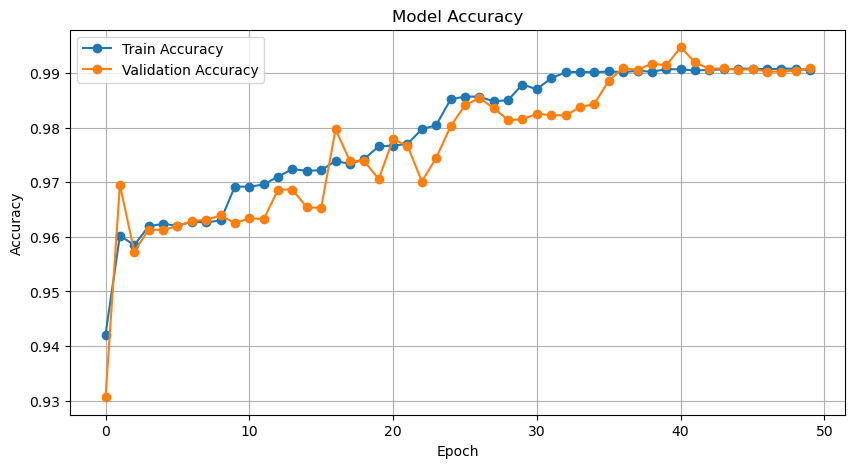

In [70]:
# Accuracy and loss plots
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("CIC_IDS_2017_Accuracy_multiclass_latest1.png")
plt.show()

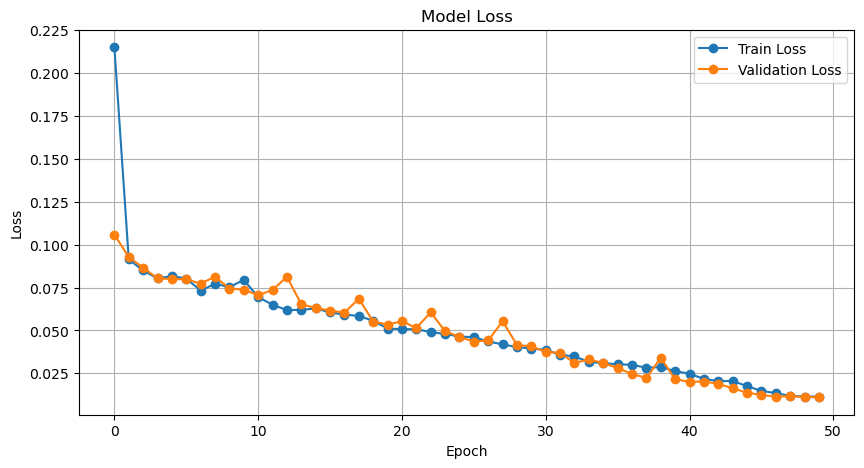

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("CIC_IDS_2017_loss_multiclass_latest1.png")
plt.show()

In [34]:
# Confusion matrix
y_pred = ensemble_model.predict([X_test_cnn, X_test_cnn, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

17729/17729 ━━━━━━━━━━━━━━━━━━━━ 292s 16ms/step


In [35]:
class_names = ['BENIGN ', 'Bot', 'DDoS','DoS GoldenEye','DoS Hulk','DoS Slowhttptest','DoS slowloris','FTP-Patator','Heartbleed','Infiltration','PortScan','SSH-Patator','Web Attack- Brute Force','Web Attack -Sql Injection','Web Attack - XSS']

In [87]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

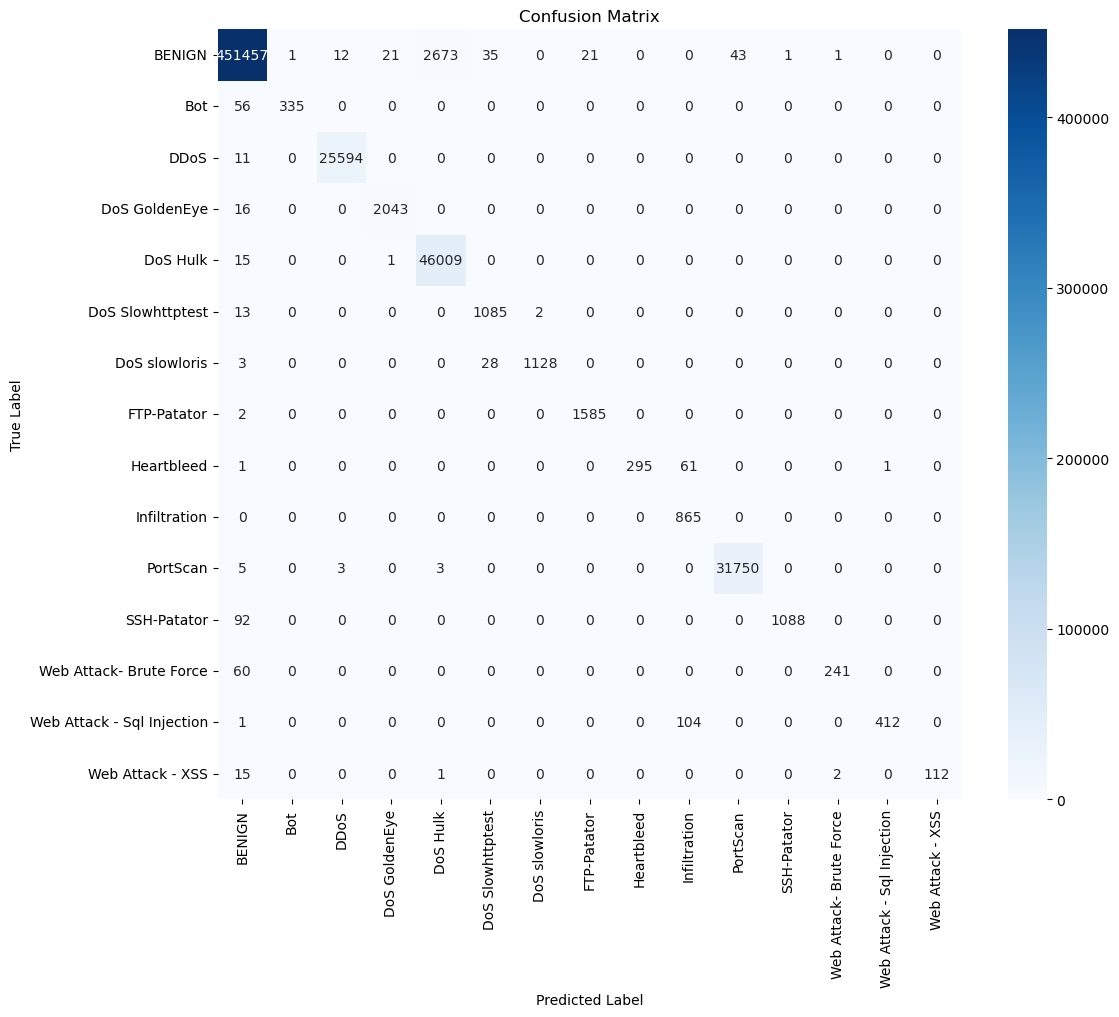

In [88]:
# Plot the confusion matrix with class names
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('CIC_IDS_2017_confusion_matrix_multiclass_latest1.png')
plt.show()

In [98]:
class_names = ['BENIGN ', 'Bot', 'DDoS','DoS GoldenEye','DoS Hulk','DoS Slowhttptest','DoS slowloris','FTP-Patator','Heartbleed','Infiltration','PortScan','SSH-Patator','Web Attack- Brute Force','Web Attack -Sql Injection','Web Attack - XSS']

In [99]:
# Generate and print the classification report with the correct target names
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0)
print(report)

                           precision    recall  f1-score   support

                  BENIGN        1.00      0.99      1.00    454265
                      Bot       1.00      0.86      0.92       391
                     DDoS       1.00      1.00      1.00     25605
            DoS GoldenEye       0.99      0.99      0.99      2059
                 DoS Hulk       0.95      1.00      0.97     46025
         DoS Slowhttptest       0.95      0.99      0.97      1100
            DoS slowloris       1.00      0.97      0.99      1159
              FTP-Patator       0.99      1.00      0.99      1587
               Heartbleed       1.00      0.82      0.90       358
             Infiltration       0.84      1.00      0.91       865
                 PortScan       1.00      1.00      1.00     31761
              SSH-Patator       1.00      0.92      0.96      1180
  Web Attack- Brute Force       0.99      0.80      0.88       301
Web Attack -Sql Injection       1.00      0.80      0.89     

In [44]:
# Correctly apply the attention mechanism to the combined features
attention_output, attention_weights = attention_mechanism(combined)

# Then, create the final output layer
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [45]:
# Extract attention weights from the model
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

17729/17729 ━━━━━━━━━━━━━━━━━━━━ 286s 16ms/step


In [46]:
avg_attention_weights = np.mean(attention_weights_test, axis=0)

In [48]:
avg_attention_weights = avg_attention_weights[:len(selected_features)]

In [49]:
selected_features = selected_features[:len(avg_attention_weights)]

In [50]:
# Create a DataFrame for visualization with actual feature names
attention_df = pd.DataFrame({
    'Feature': selected_features,  # Use the actual feature names
    'Attention Weight': avg_attention_weights
})

# Print the DataFrame to inspect
print(attention_df)

                        Feature  Attention Weight
0        Total Backward Packets          0.023620
1   Total Length of Fwd Packets          0.023553
2   Total Length of Bwd Packets          0.023000
3         Fwd Packet Length Max          0.021666
4         Fwd Packet Length Min          0.019763
5         Fwd Packet Length Std          0.023082
6         Bwd Packet Length Min          0.021174
7         Bwd Packet Length Std          0.021446
8                  Flow IAT Std          0.021975
9                  Flow IAT Max          0.020105
10                 Flow IAT Min          0.024726
11                  Fwd IAT Max          0.021202
12                  Fwd IAT Min          0.020912
13                 Bwd IAT Mean          0.022499
14                  Bwd IAT Max          0.020975
15                  Bwd IAT Min          0.022885
16                Fwd URG Flags          0.022209
17            Fwd Header Length          0.023723
18            Bwd Header Length          0.020611


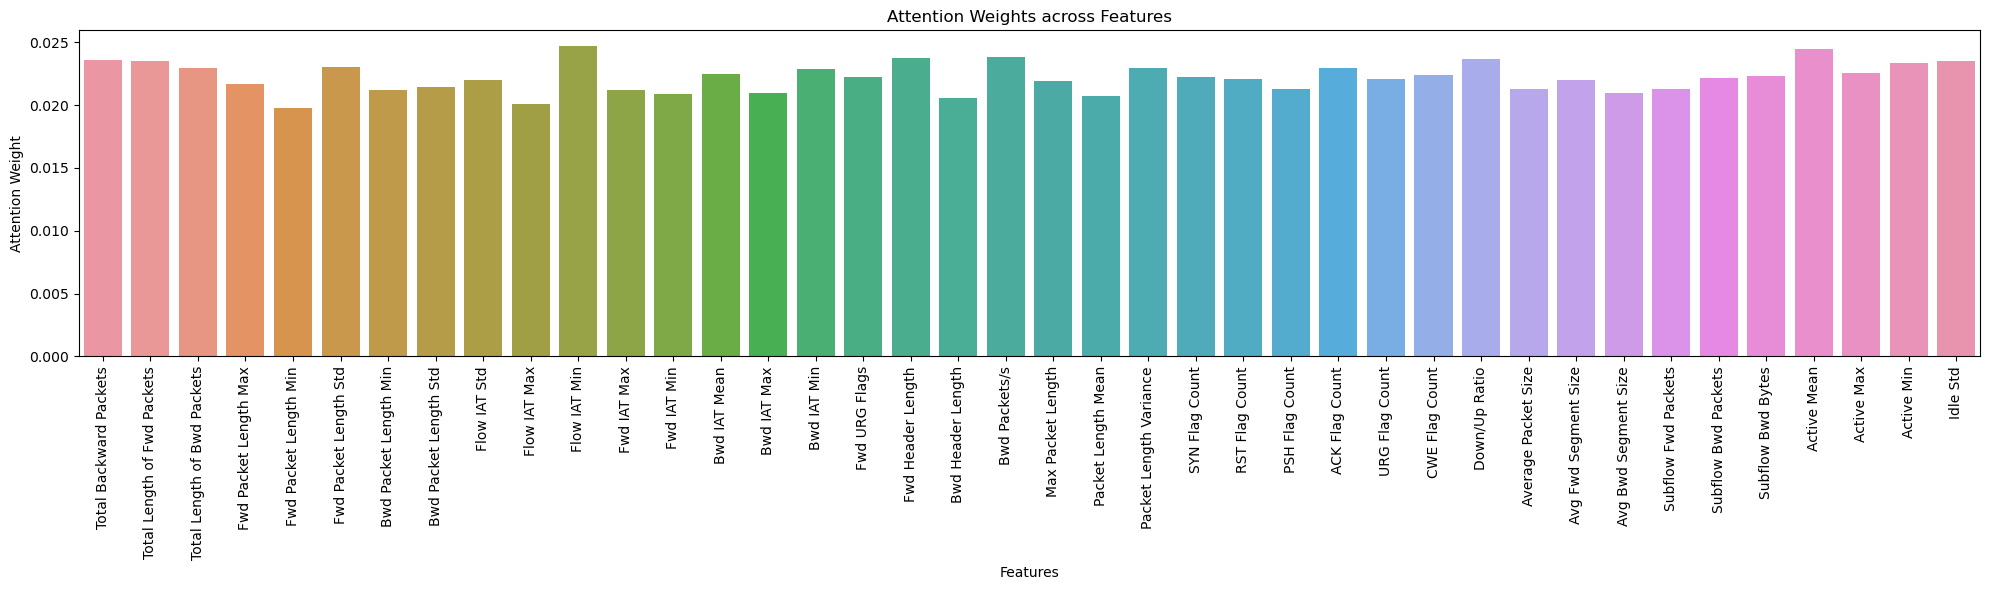

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the attention weights
plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Attention Weight', data=attention_df)
plt.title('Attention Weights across Features')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('attention_weights_plot.png')  # Save the plot as an image file
plt.show() 

Shape of attention_weights_test: (567303, 40)
17729/17729 ━━━━━━━━━━━━━━━━━━━━ 296s 17ms/step


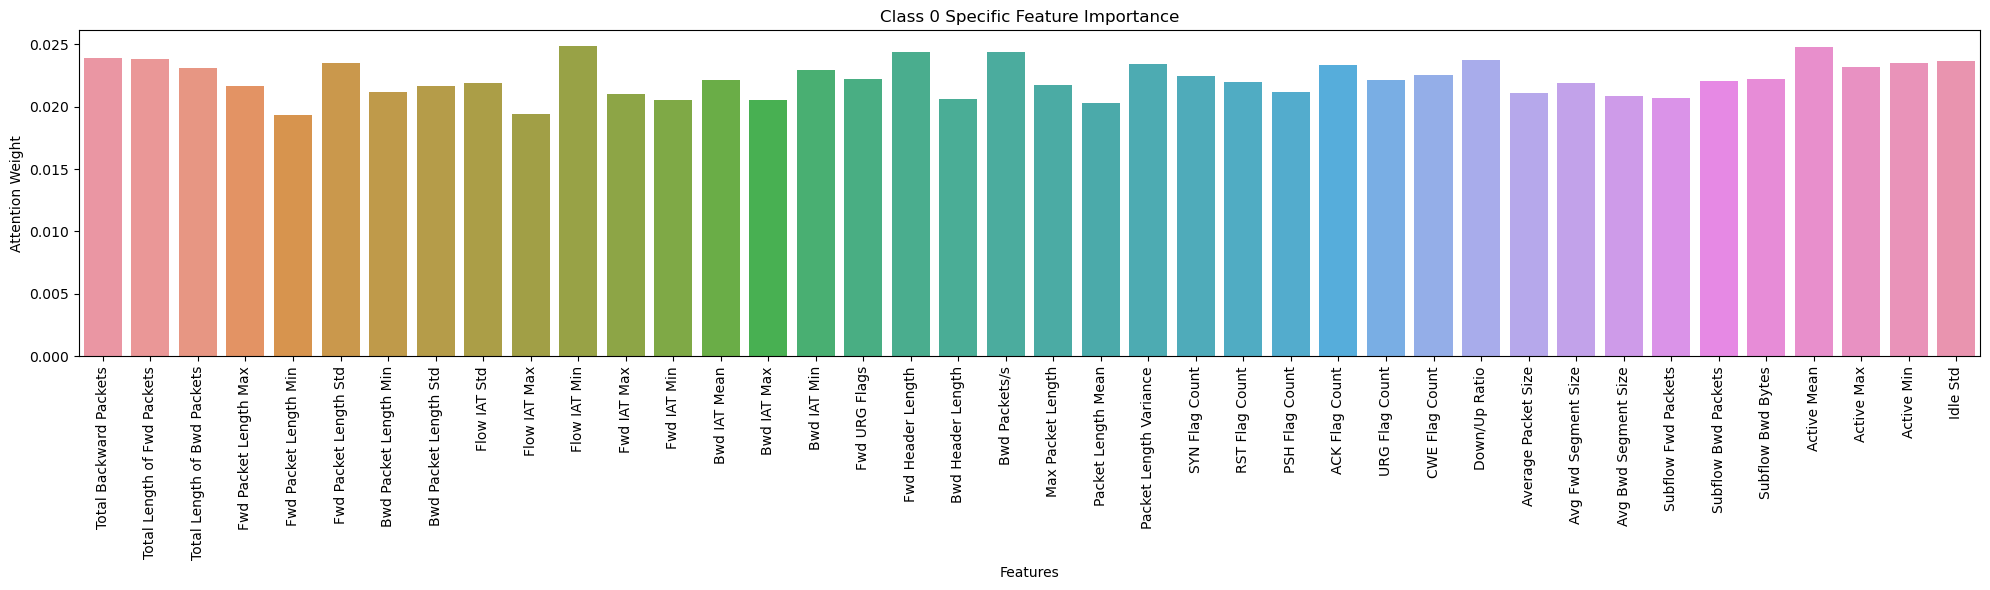

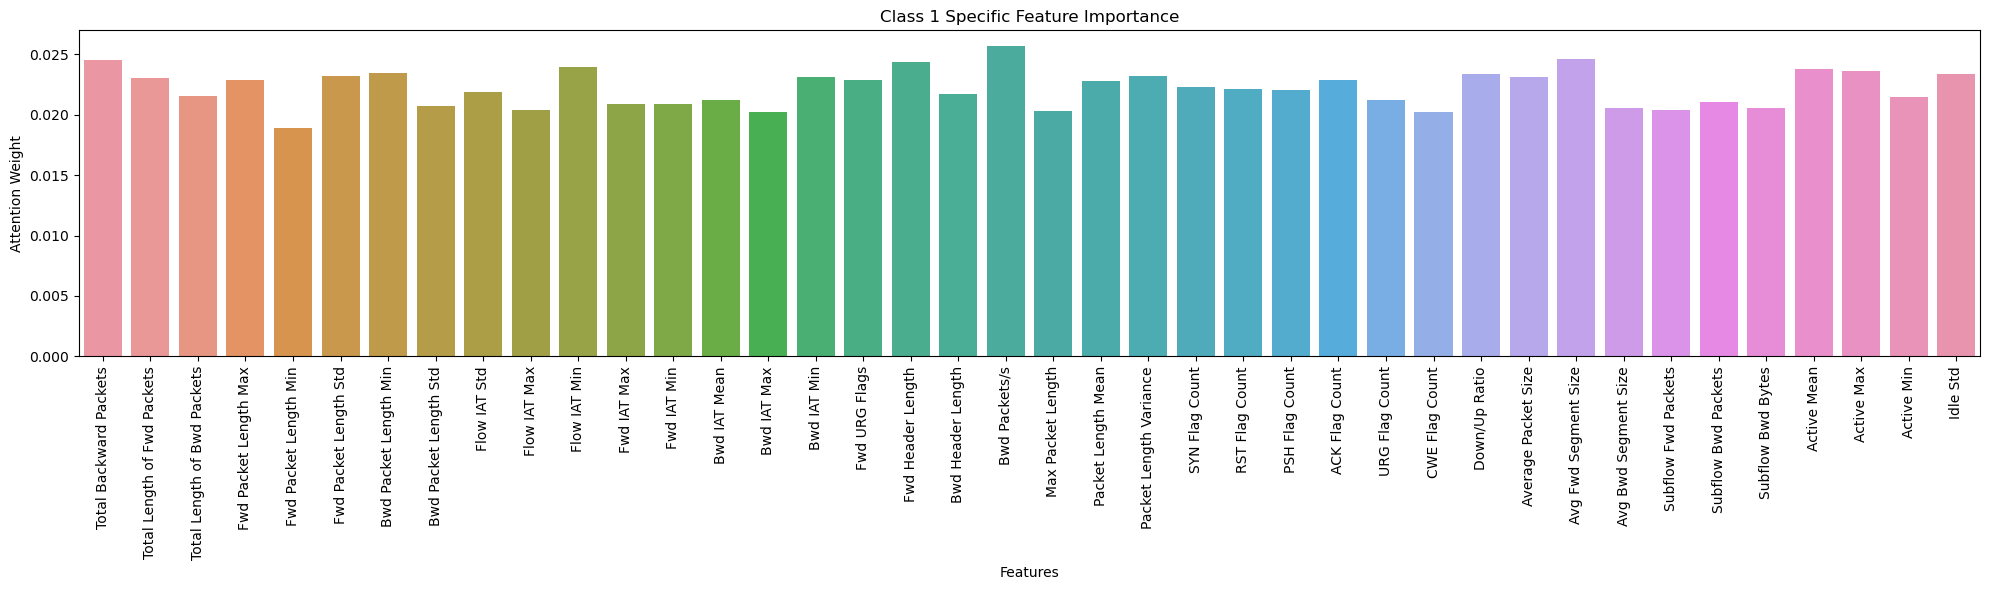

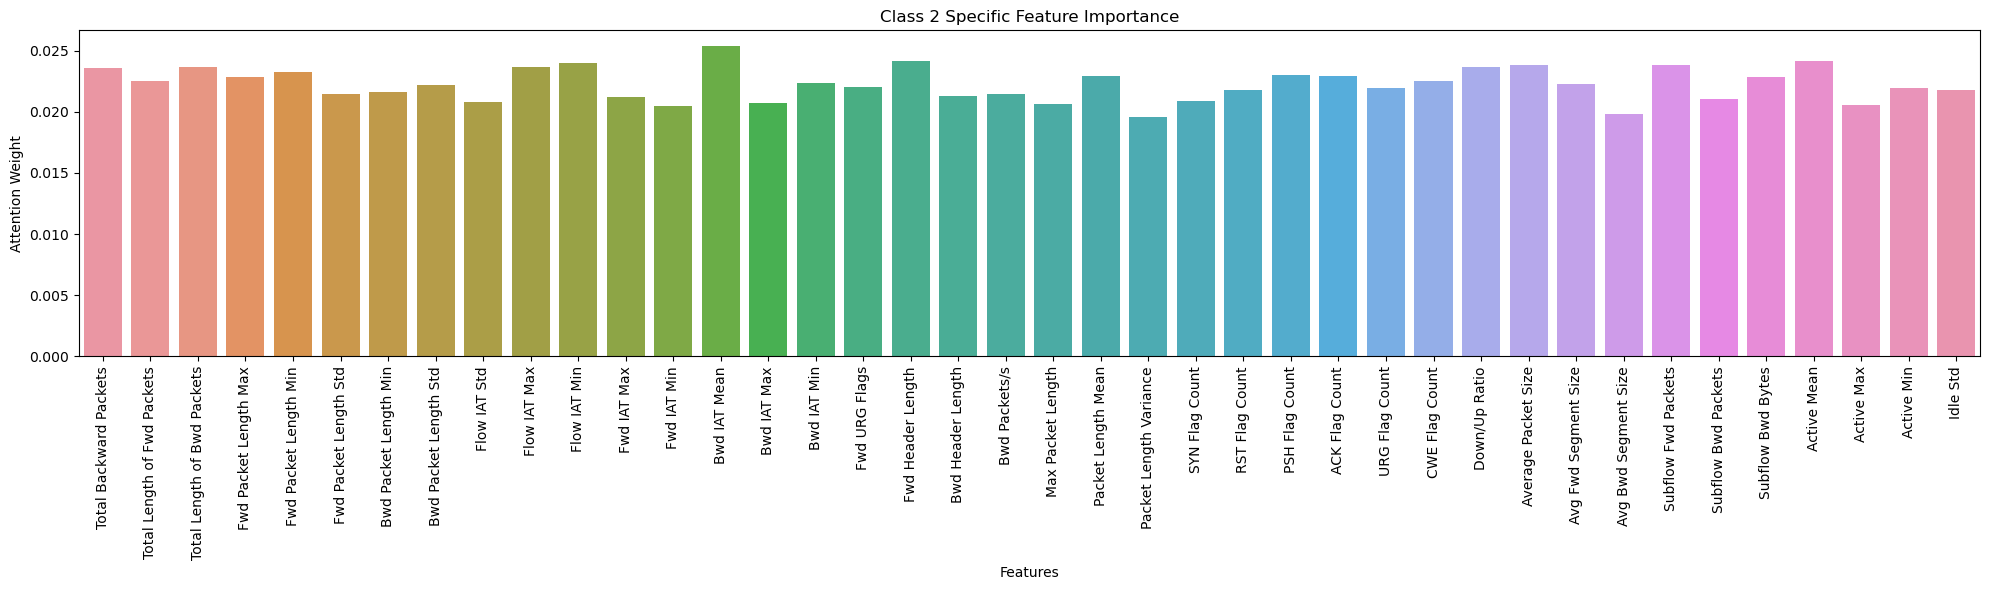

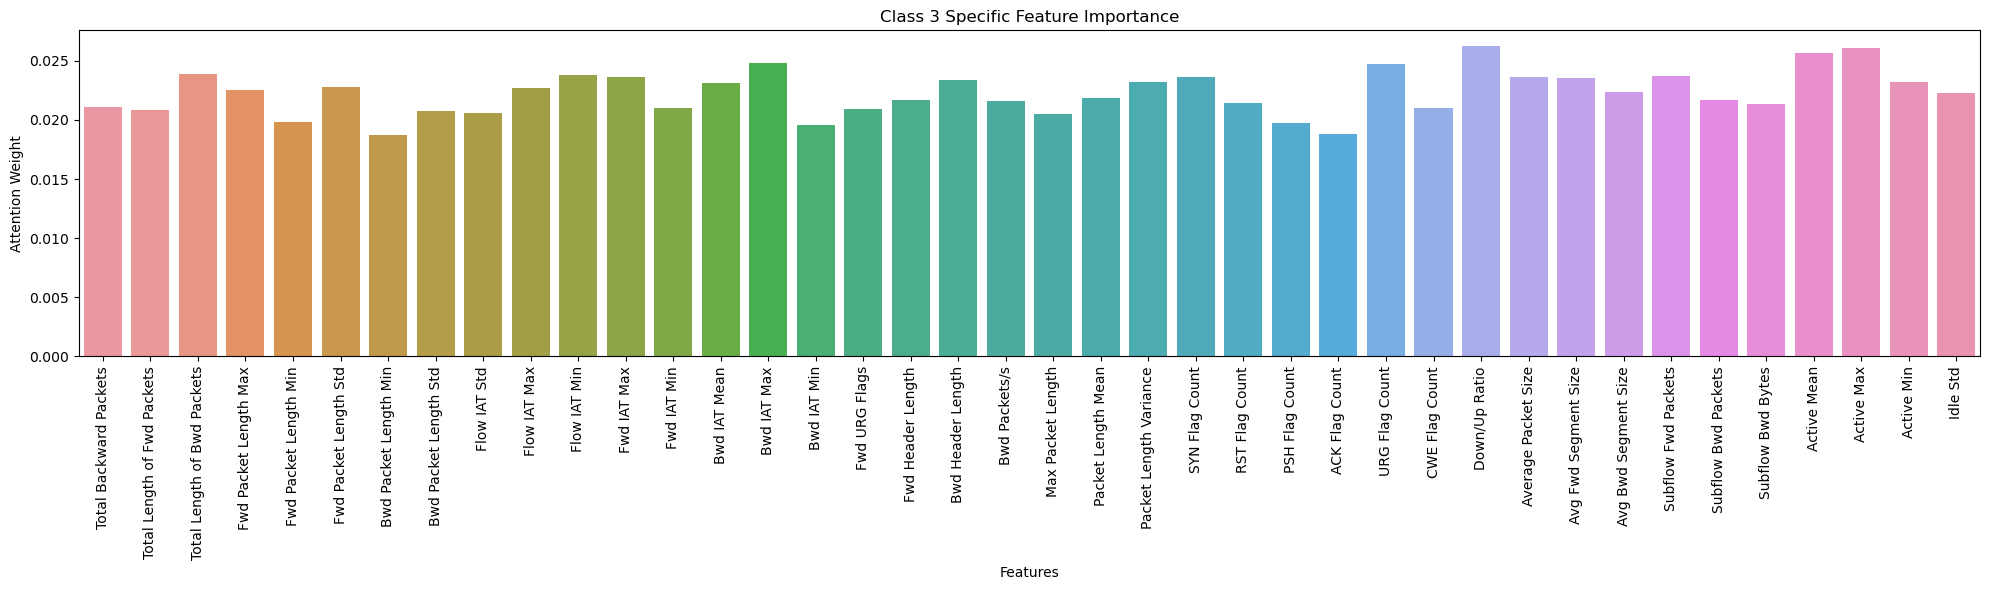

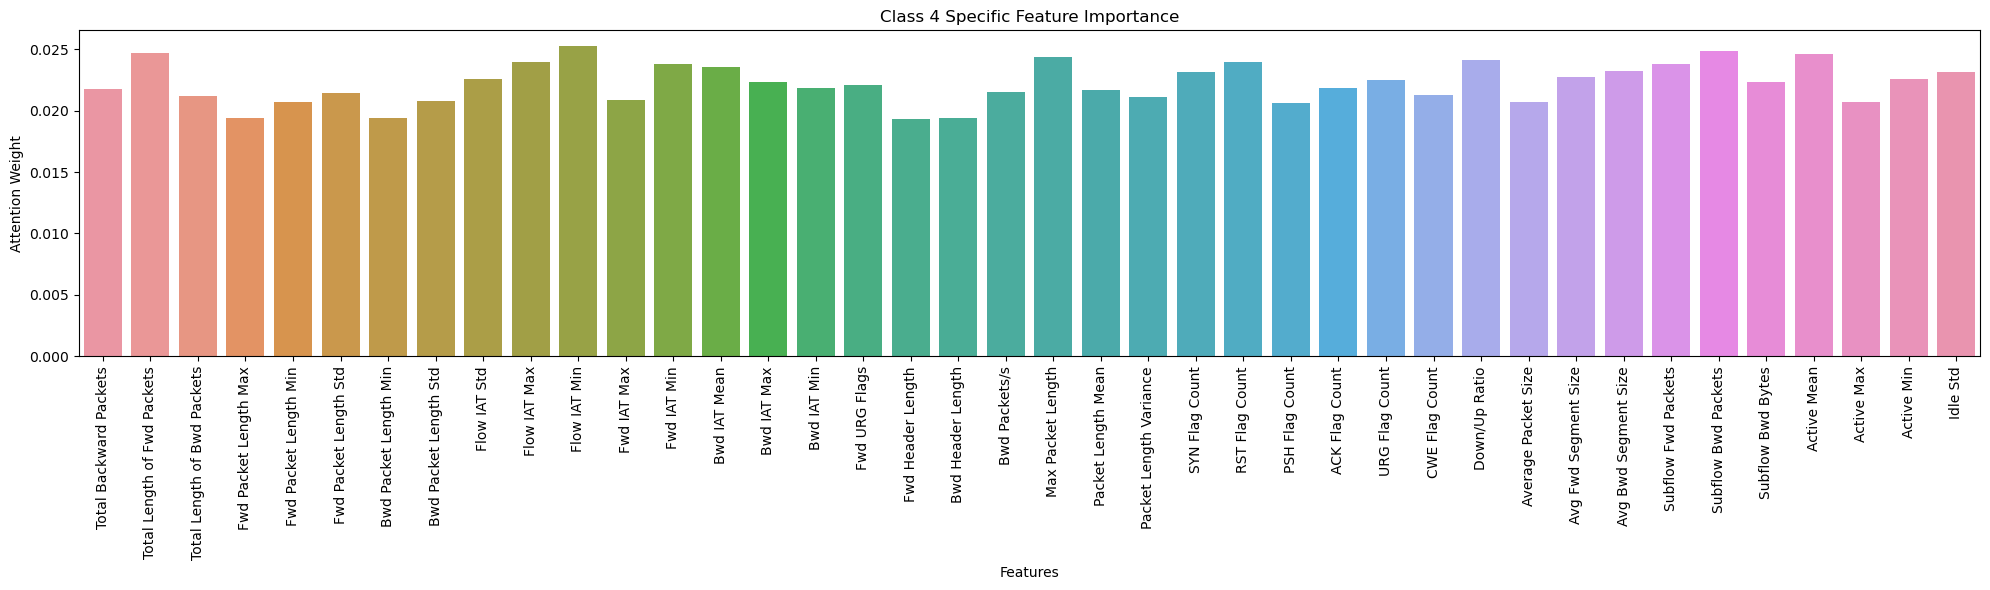

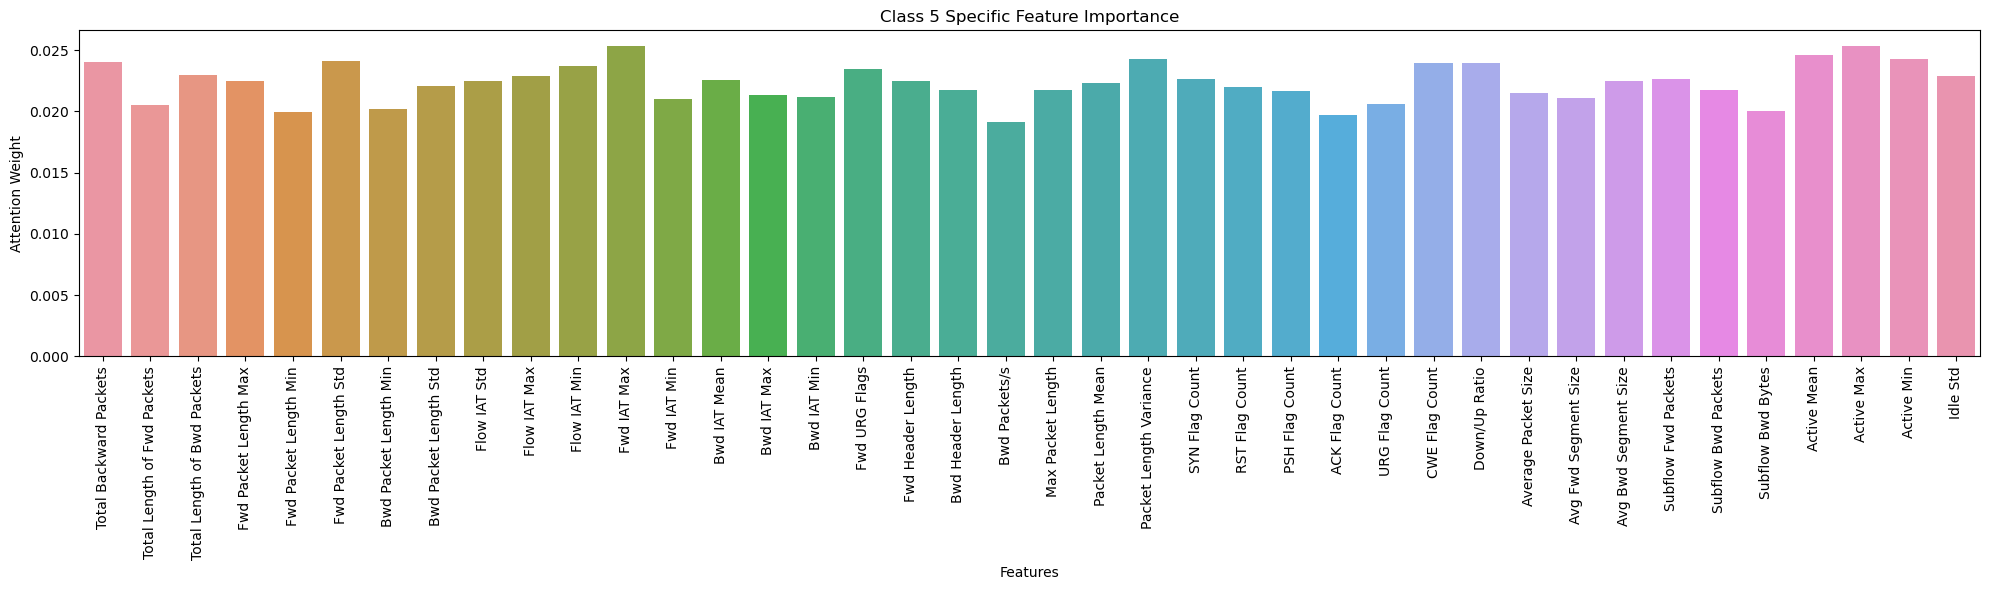

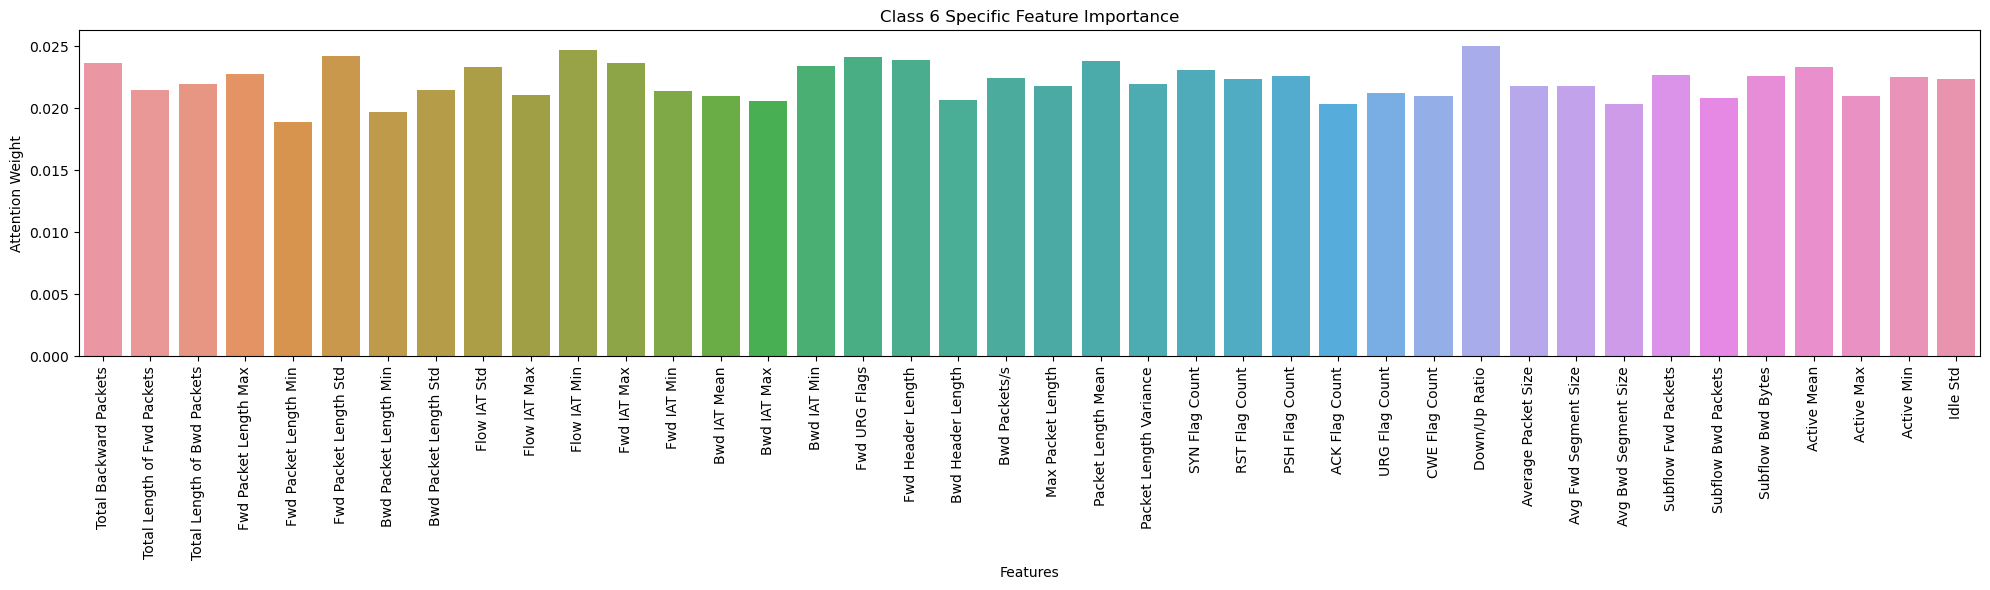

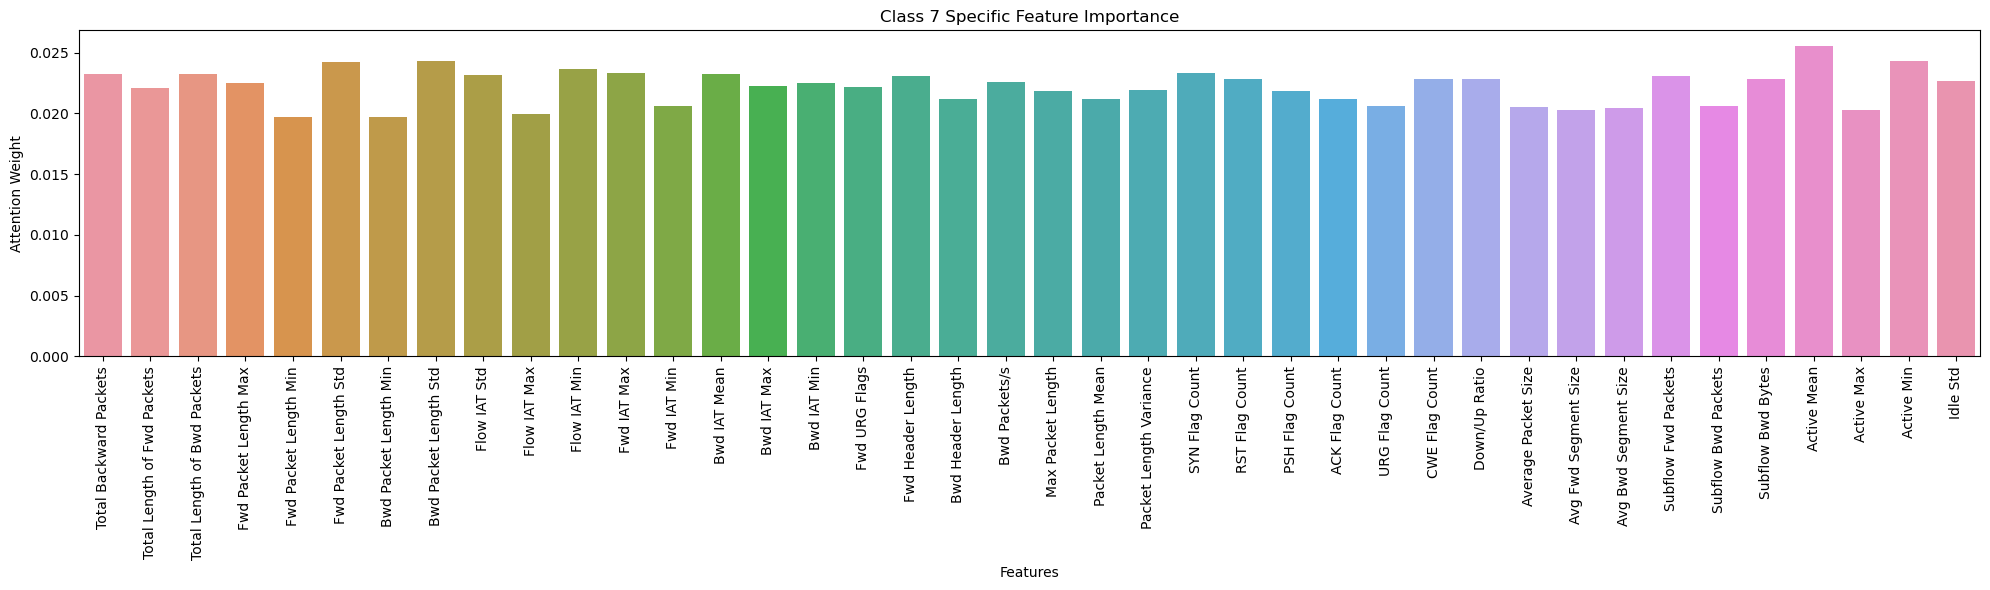

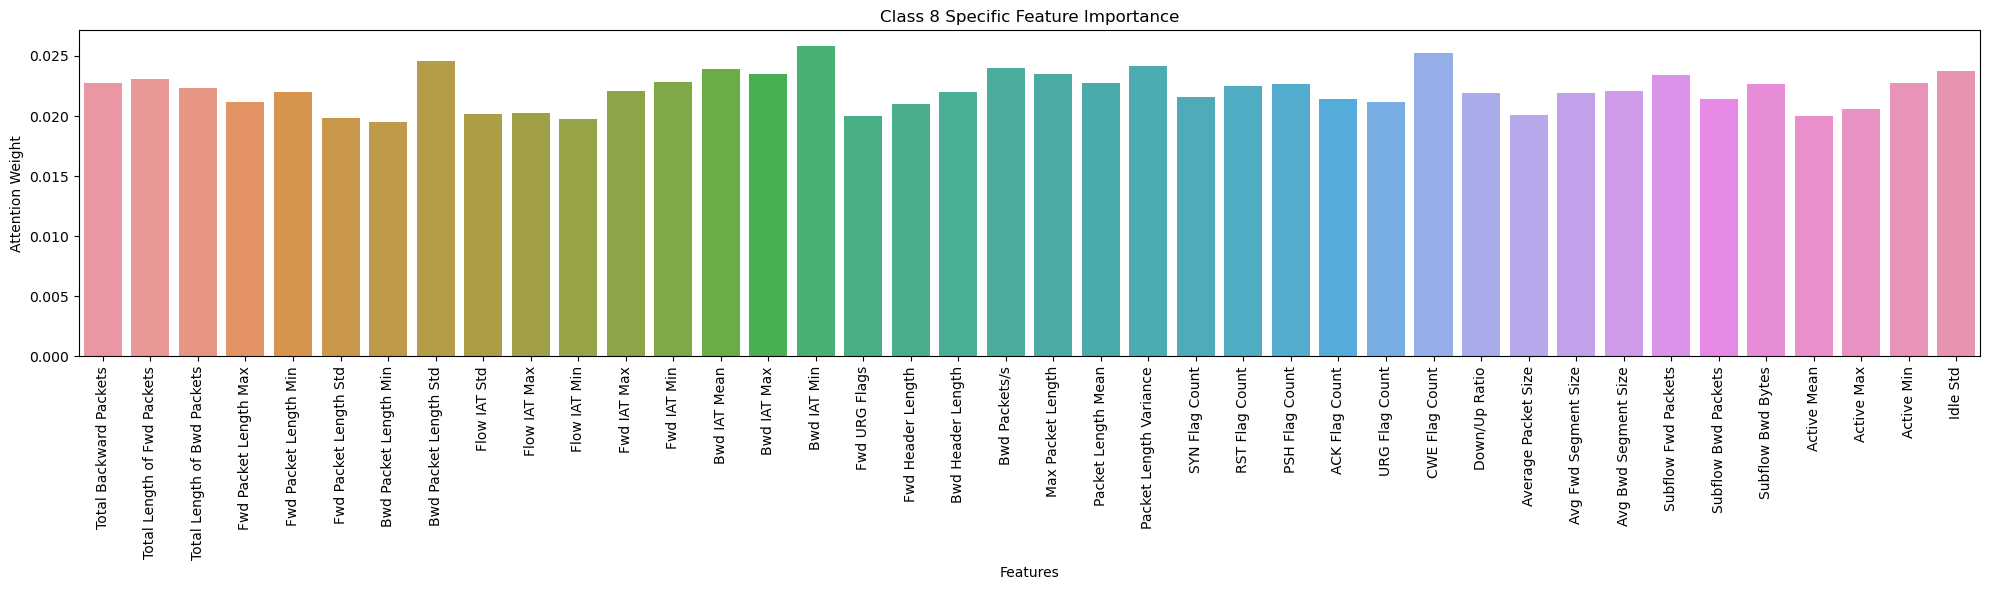

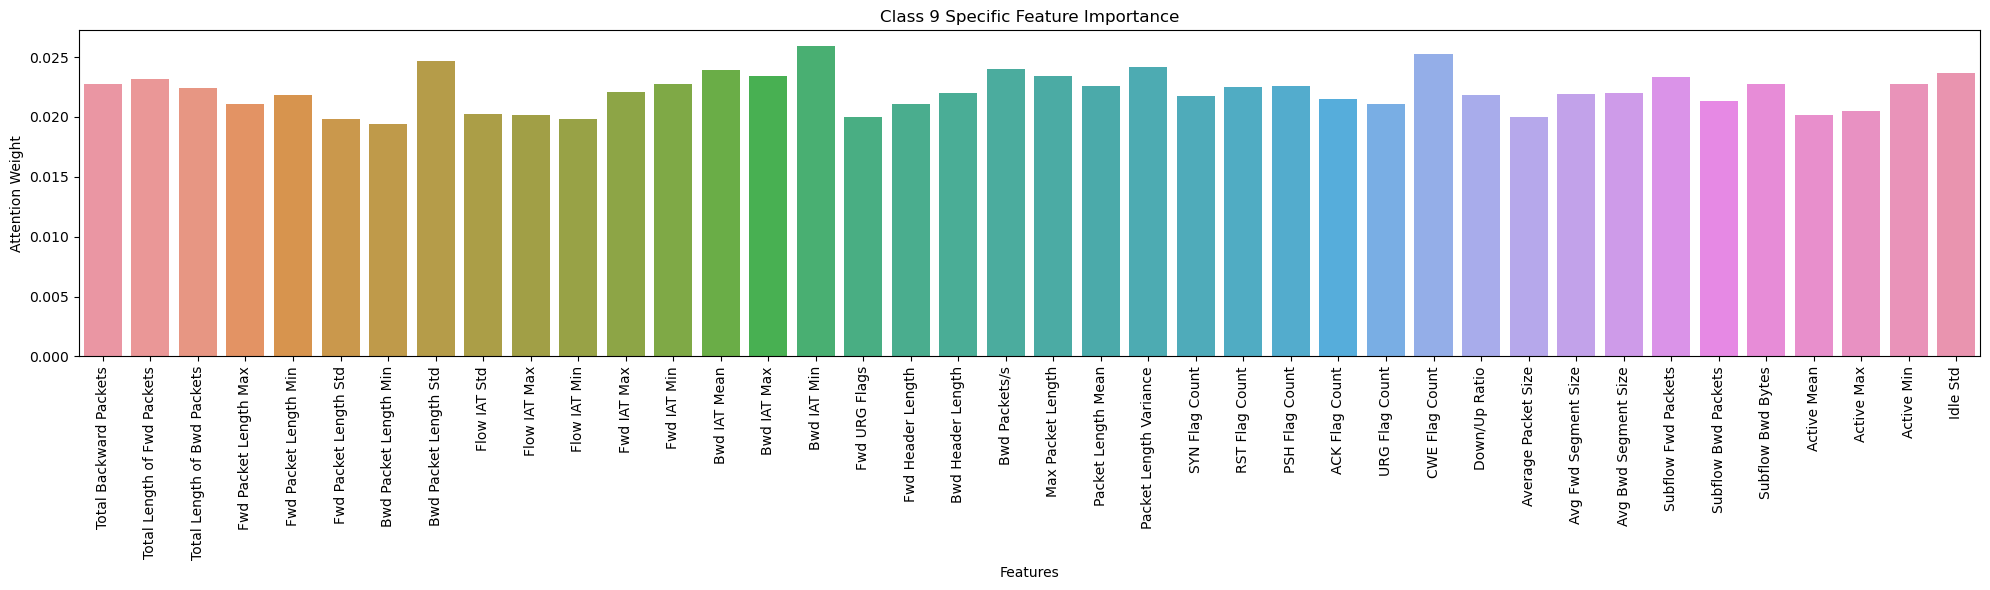

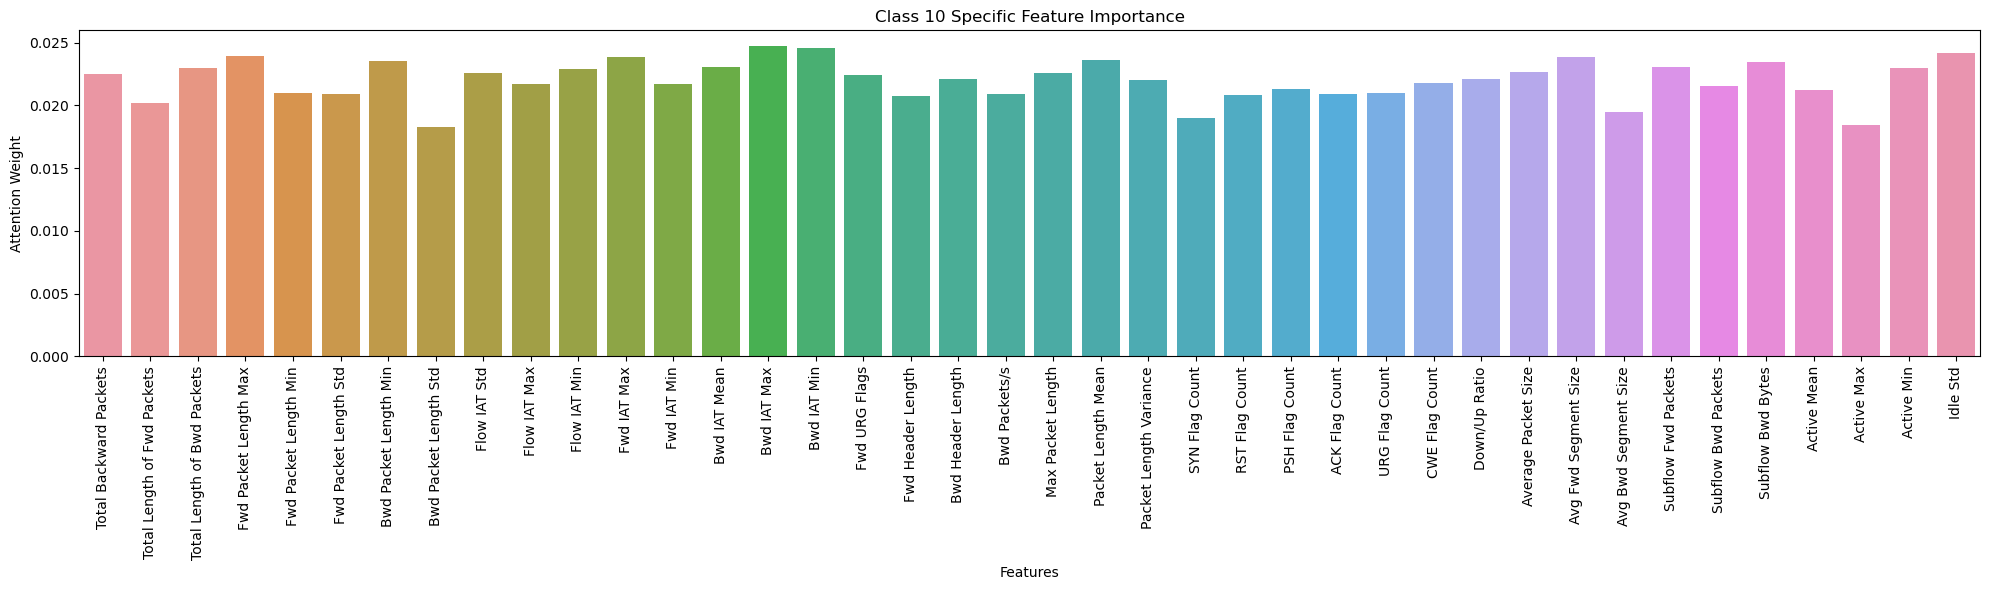

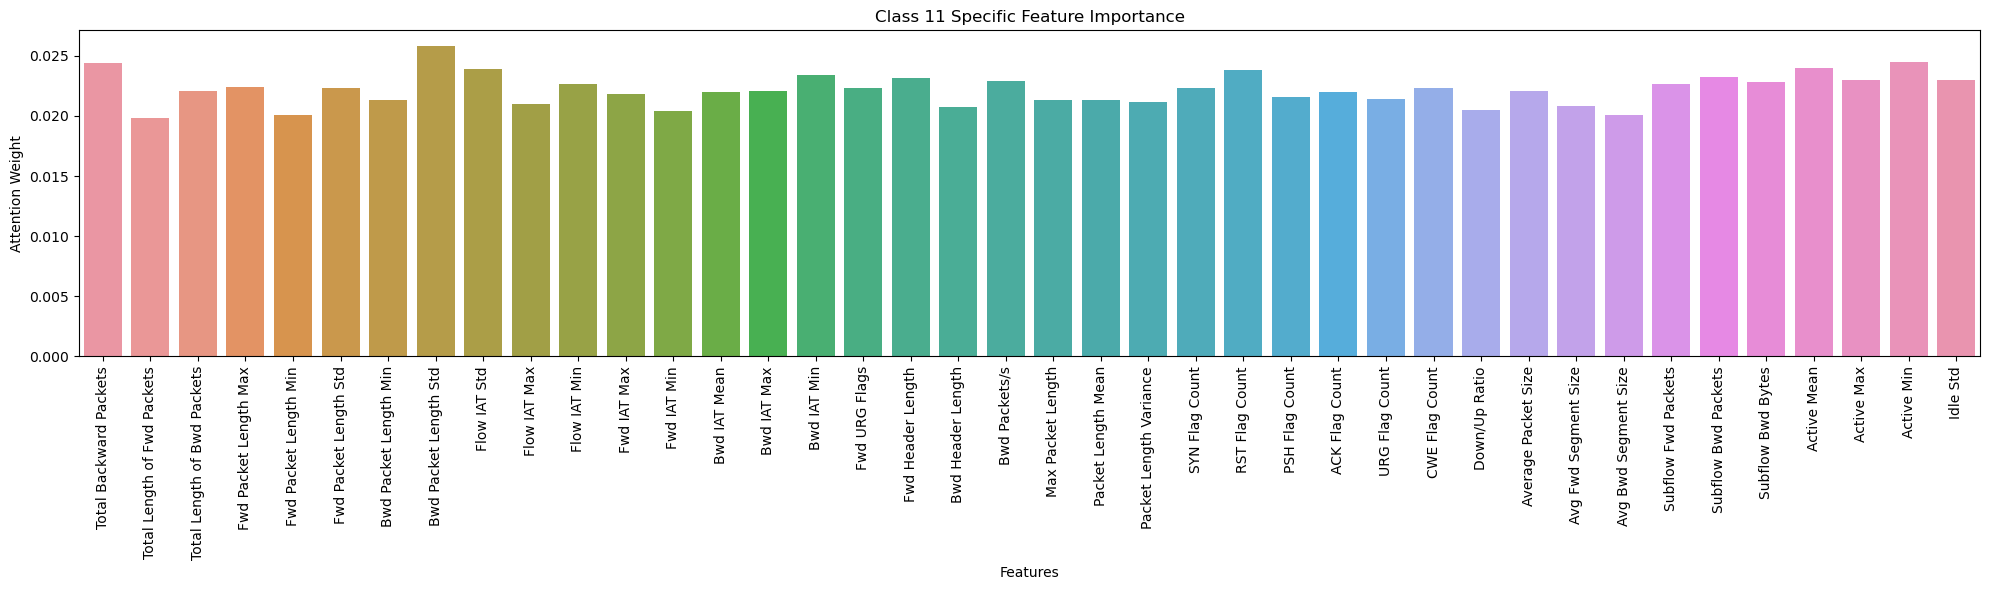

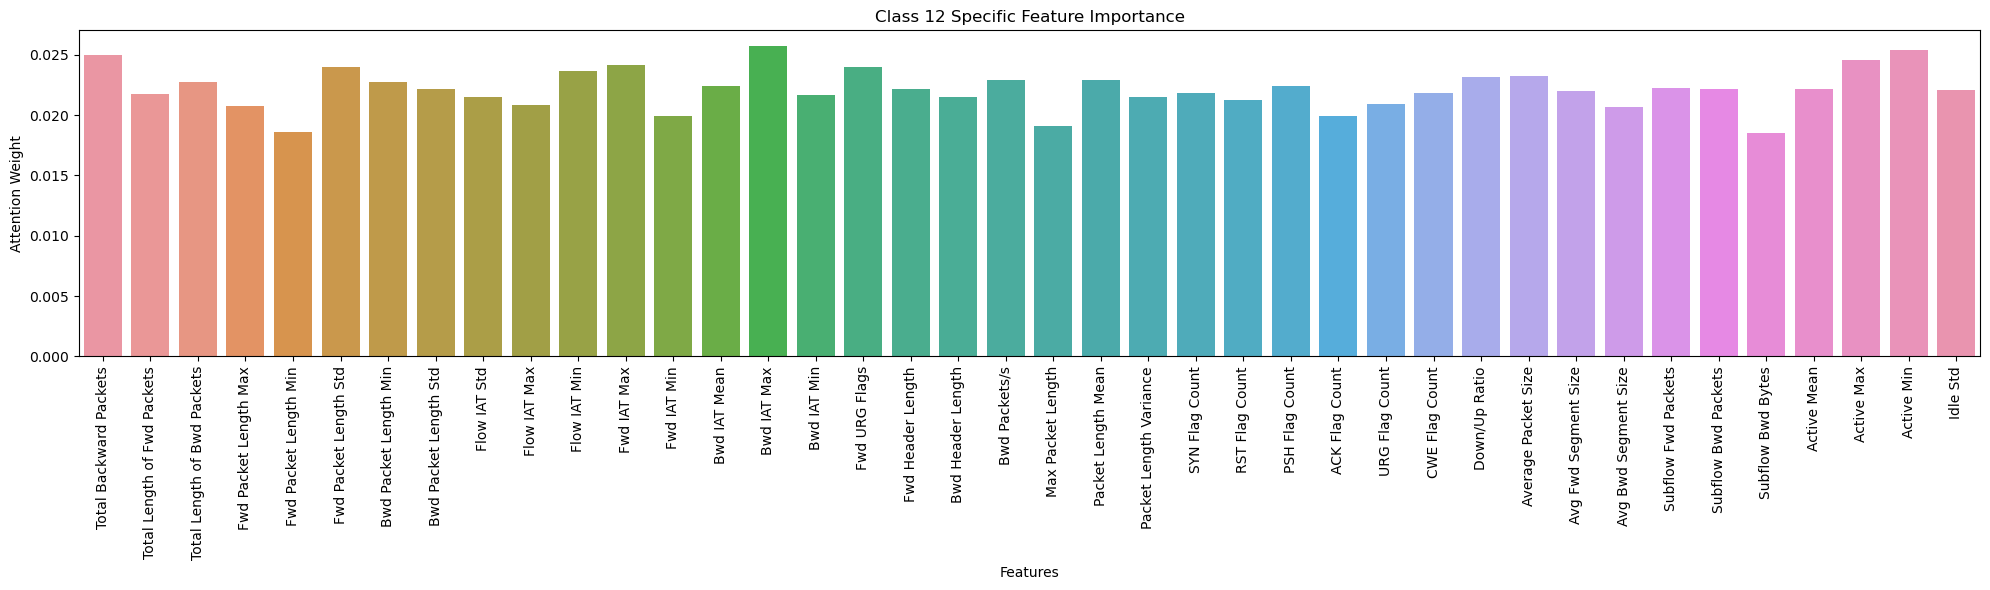

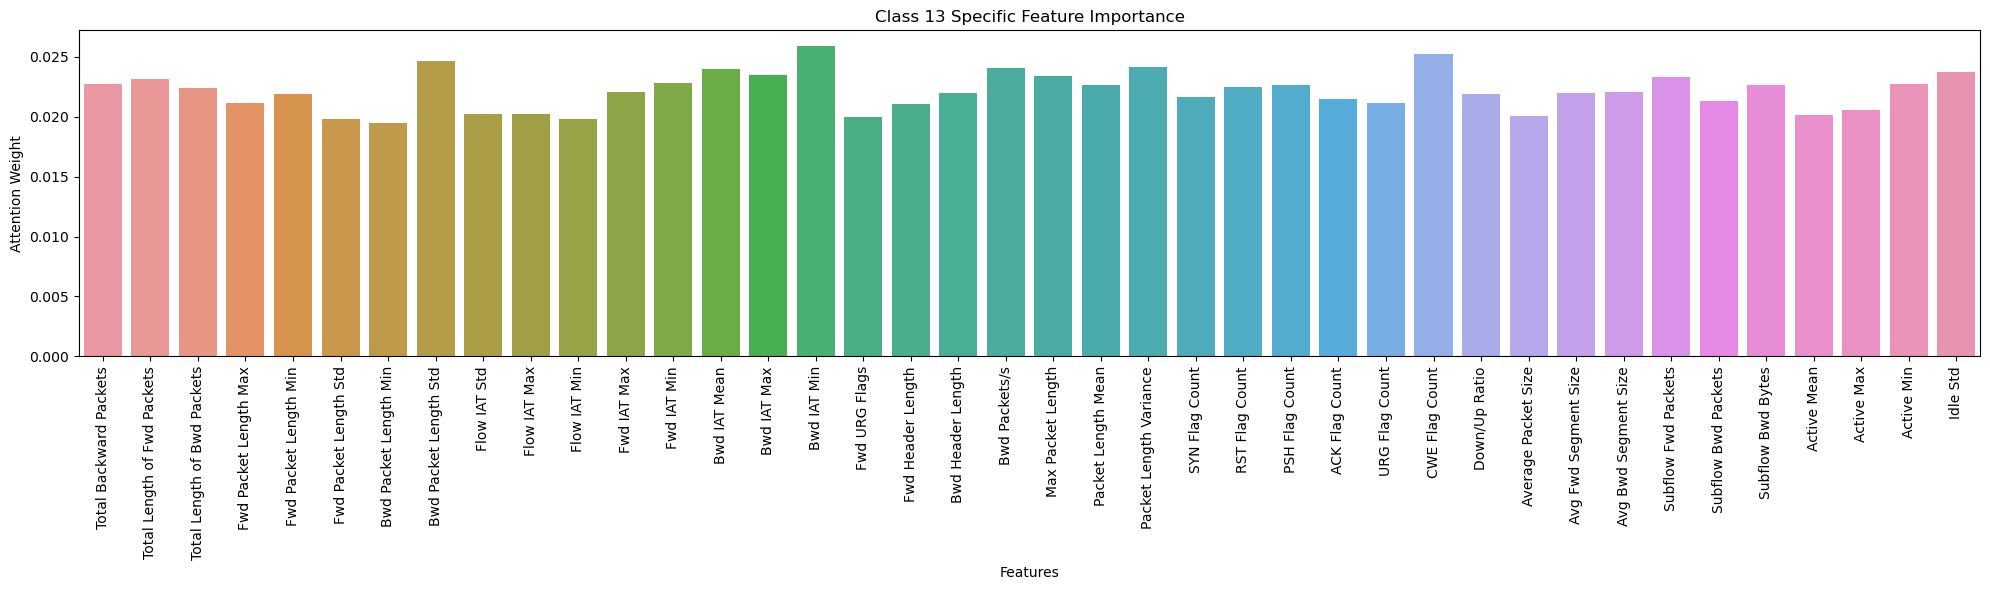

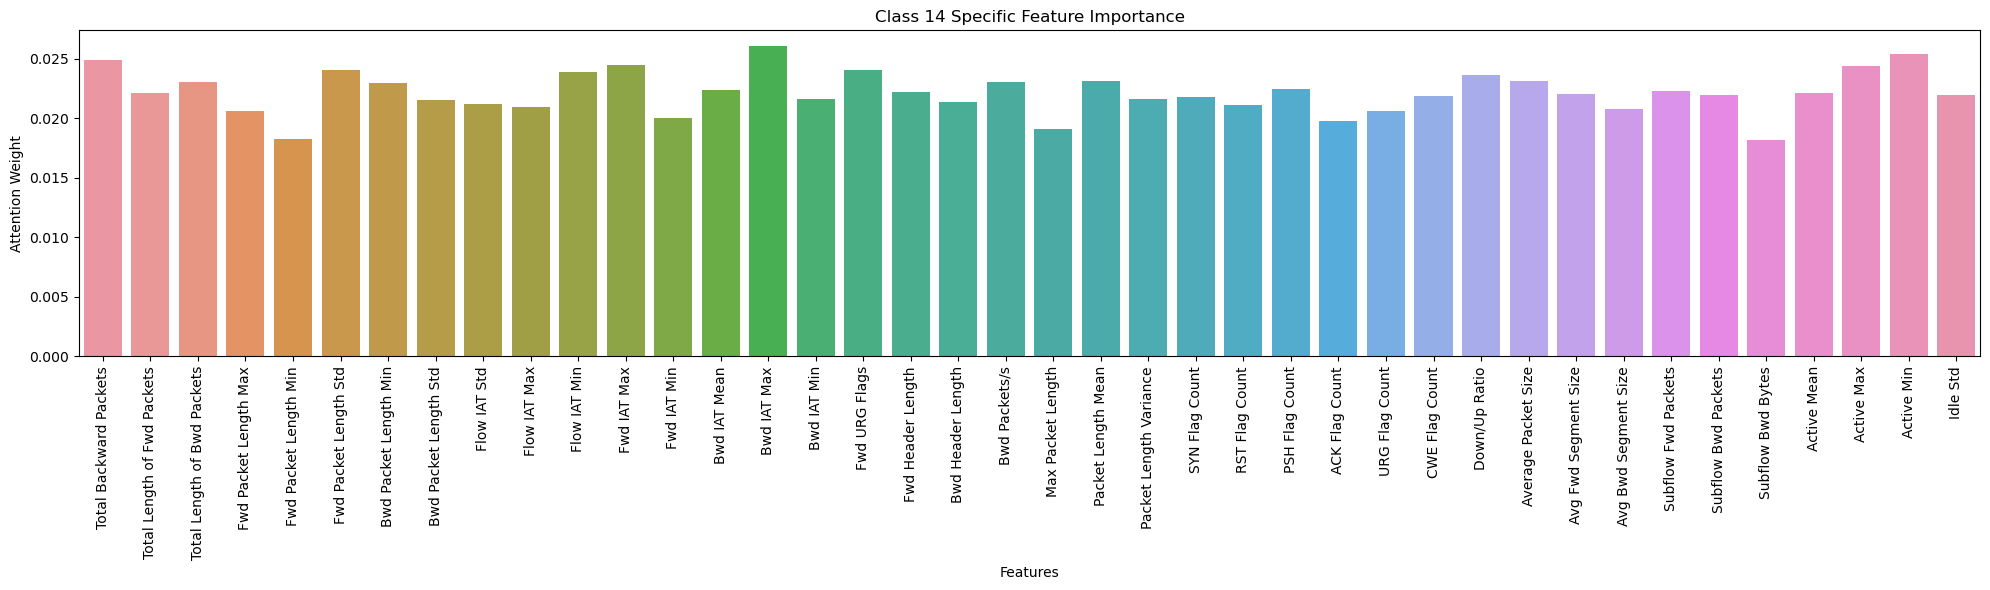

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Print shape of attention weights to investigate
print(f"Shape of attention_weights_test: {attention_weights_test.shape}")

# Truncate the attention weights if they have more features than selected
attention_weights_test = attention_weights_test[:, :len(selected_features)]

# Get the predicted classes
y_pred_classes = np.argmax(ensemble_model.predict([X_test_cnn, X_test_cnn, X_test]), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Initialize an array to store class-specific attention weights
num_classes = y_test.shape[1]
class_specific_weights = np.zeros((num_classes, len(selected_features)))

# Compute average attention weights per class
for class_idx in range(num_classes):
    class_indices = np.where(y_true_classes == class_idx)[0]
    if len(class_indices) > 0:
        class_specific_weights[class_idx] = np.mean(attention_weights_test[class_indices], axis=0)
    else:
        print(f"No samples found for class {class_idx}.")

# Plot the attention weights for each class
for class_idx in range(num_classes):
    plt.figure(figsize=(20, 6))
    sns.barplot(x=selected_features, y=class_specific_weights[class_idx])
    plt.title(f'Class {label_encoder.classes_[class_idx]} Specific Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Attention Weight')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'class_{label_encoder.classes_[class_idx]}_attention_weights.png')
    plt.show()


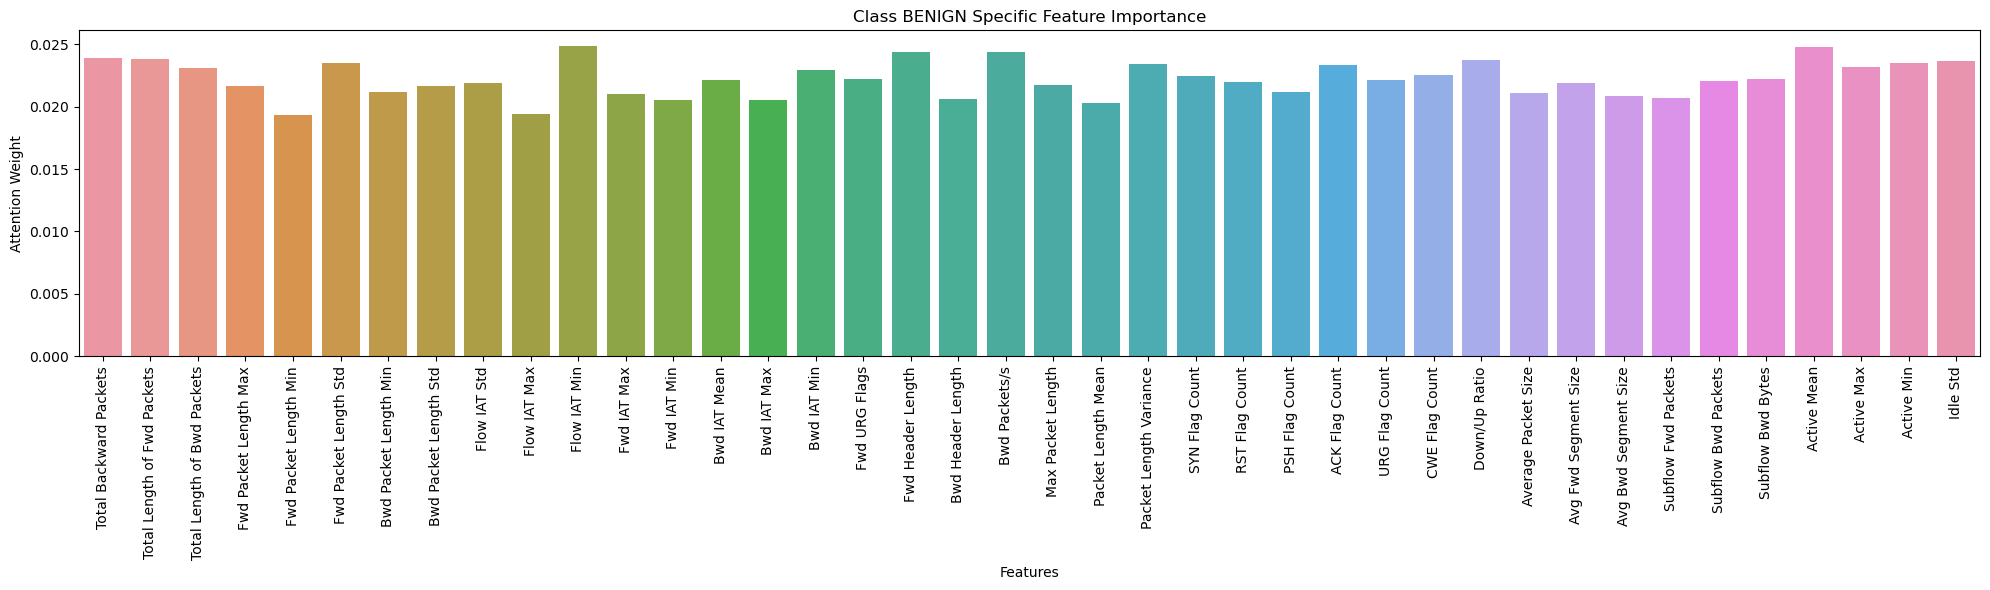

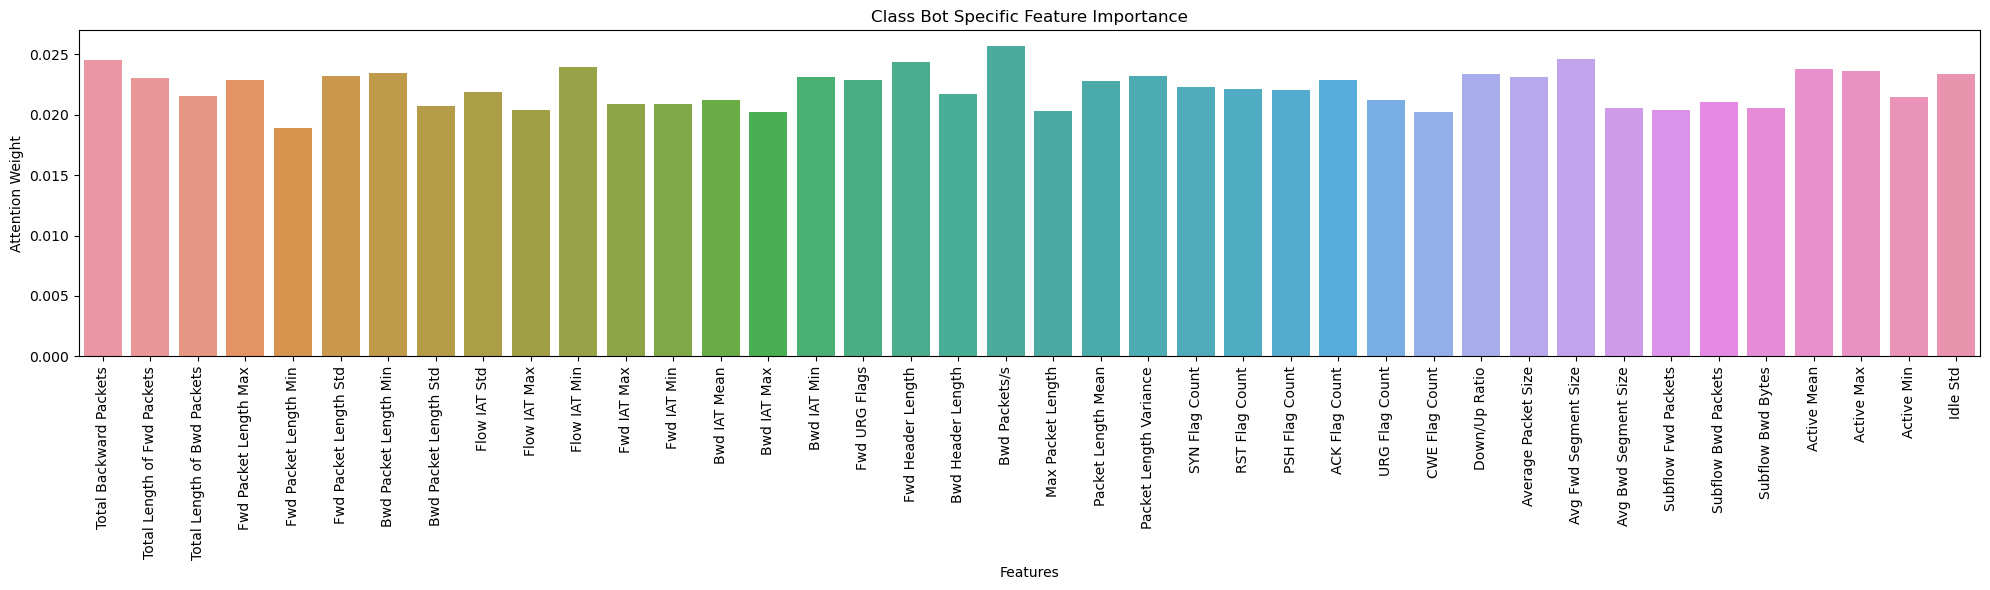

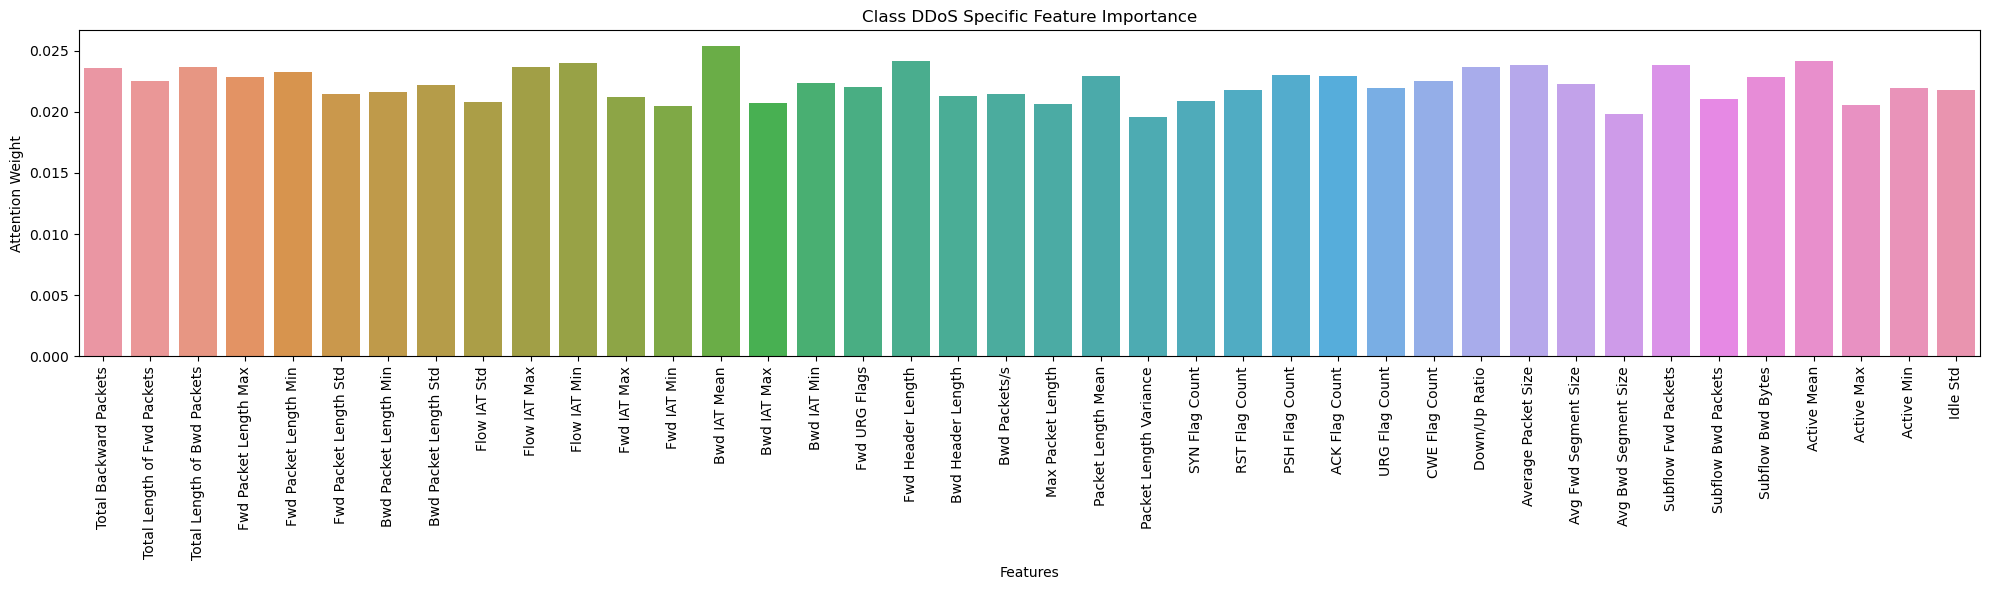

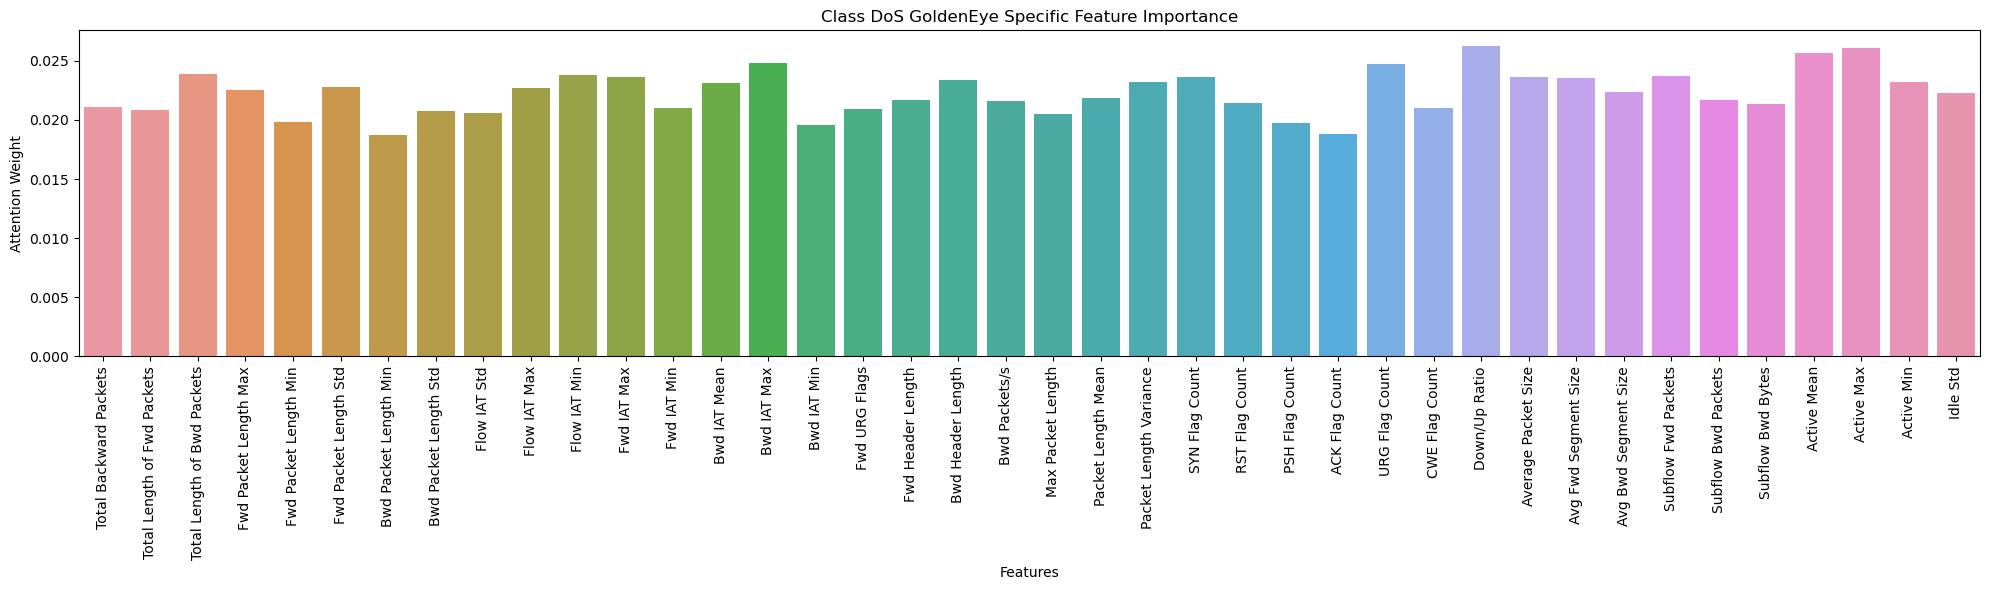

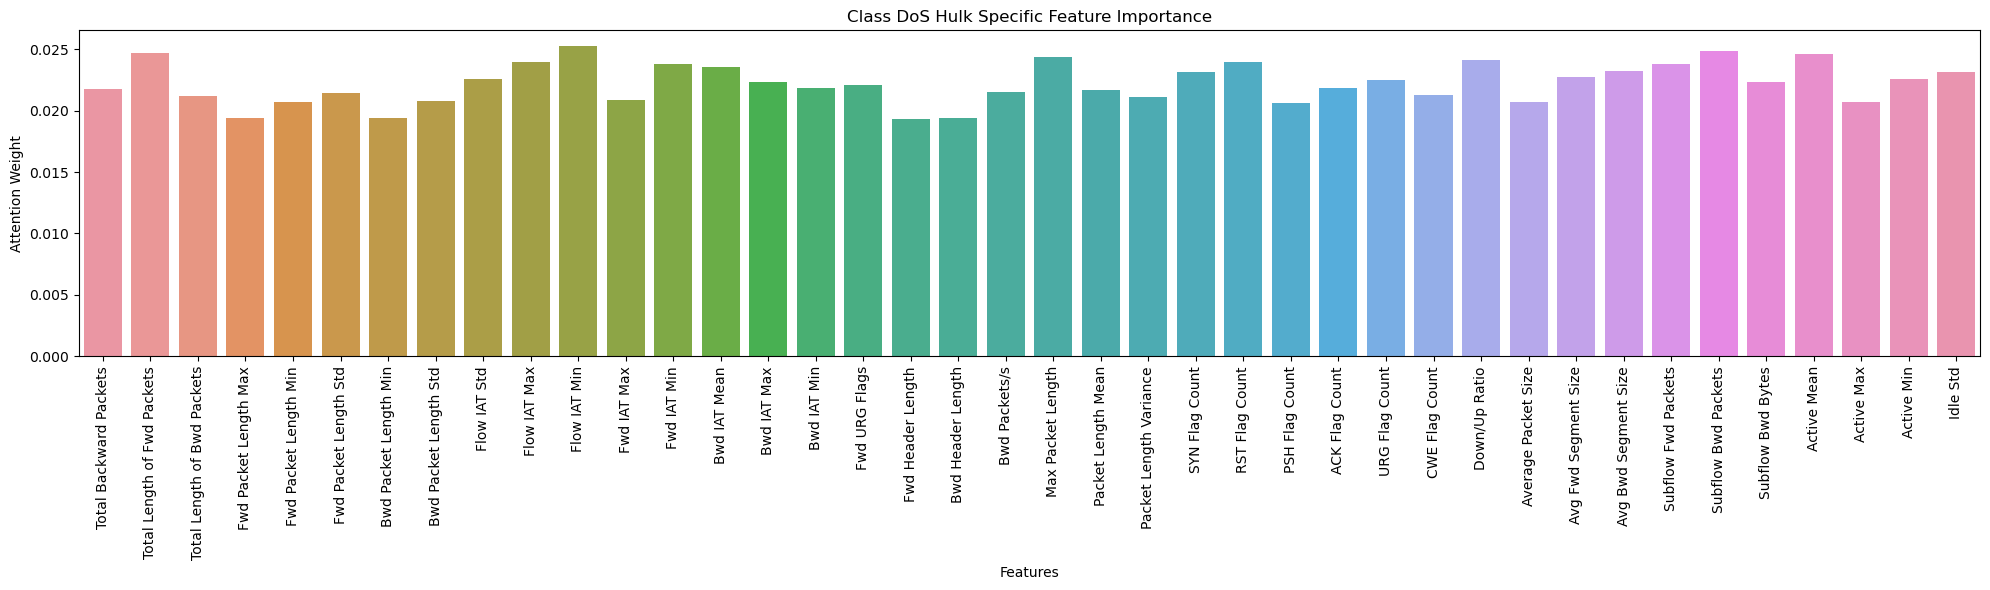

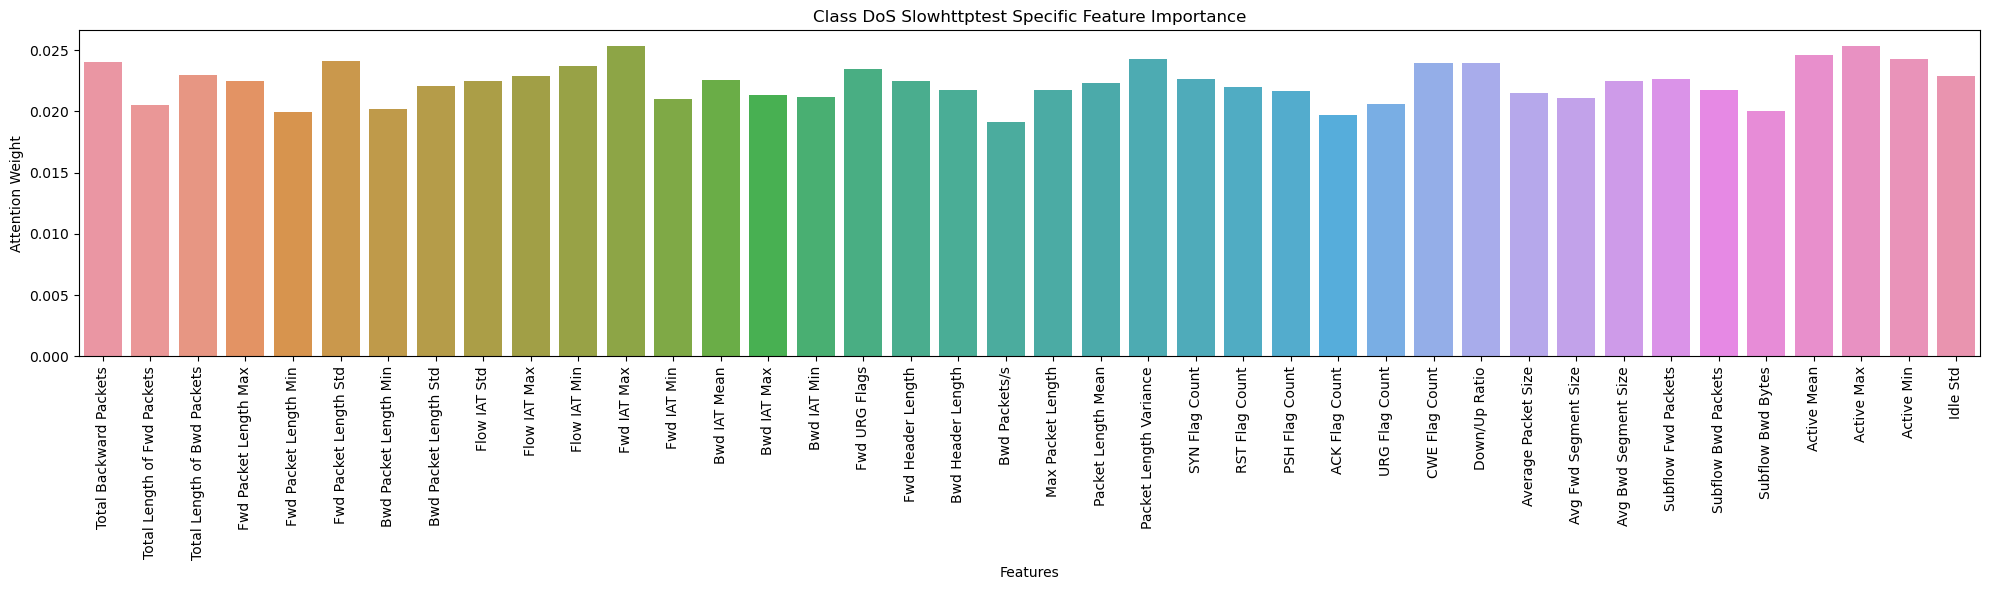

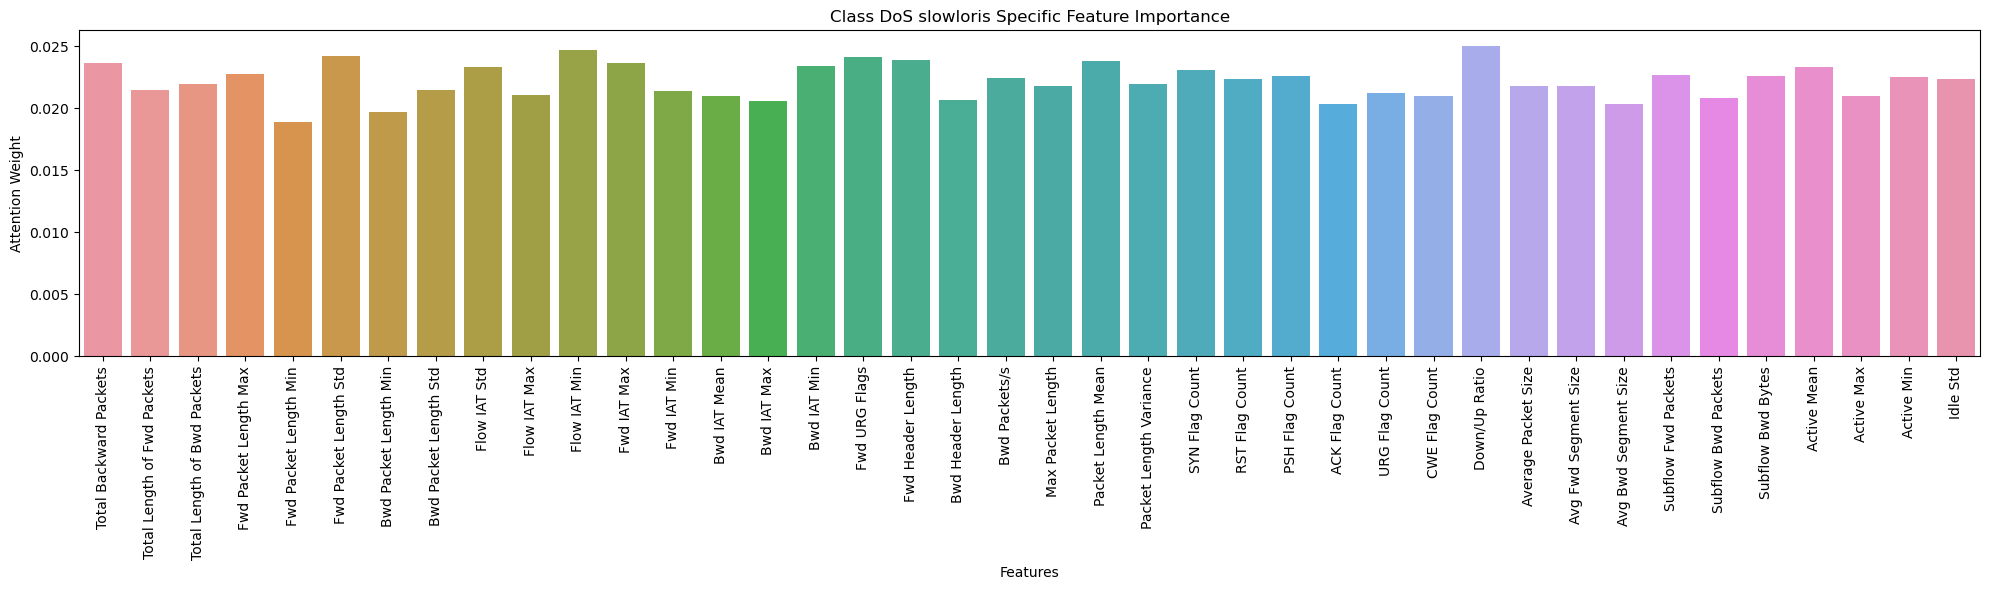

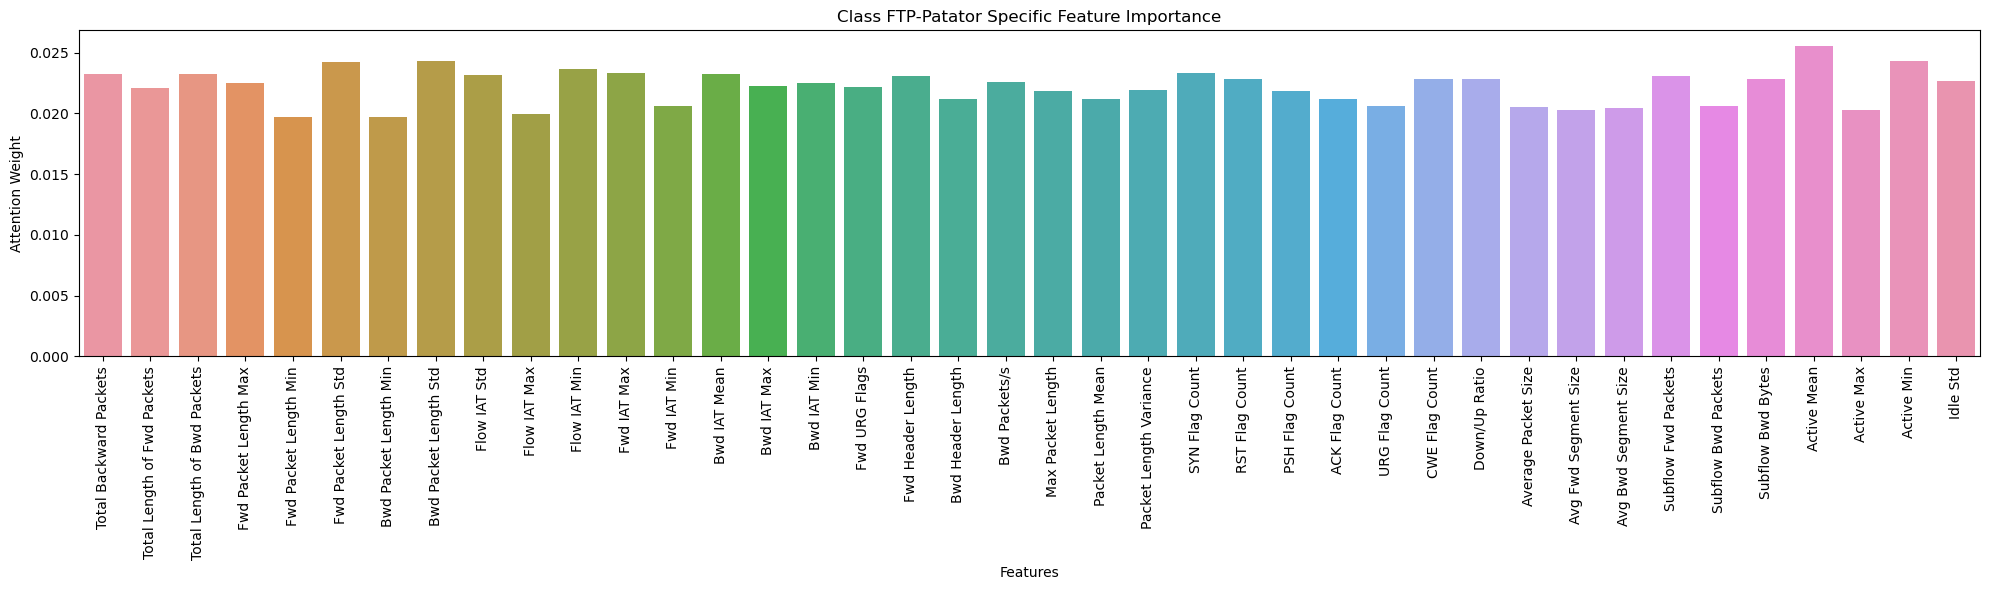

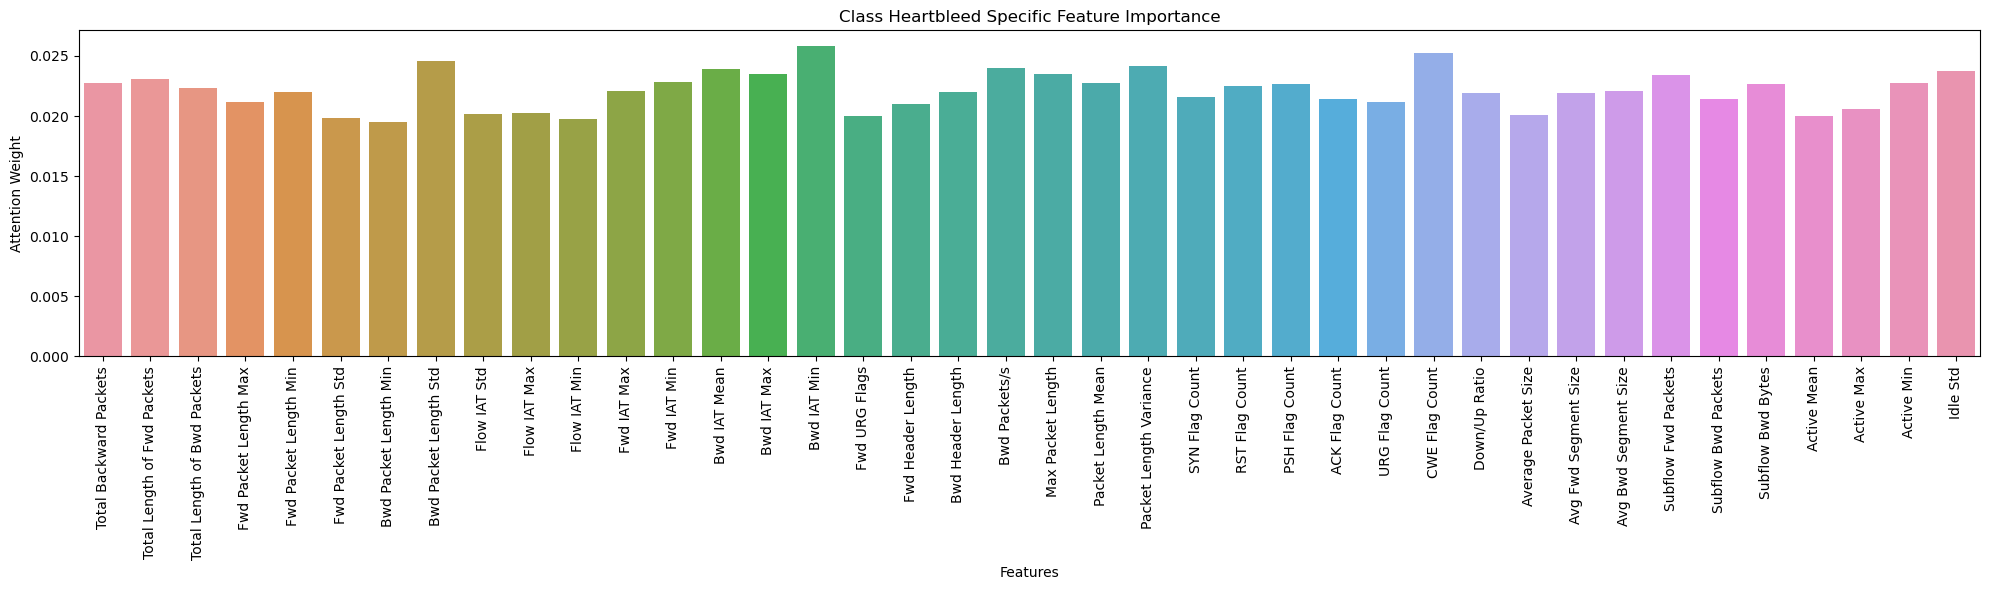

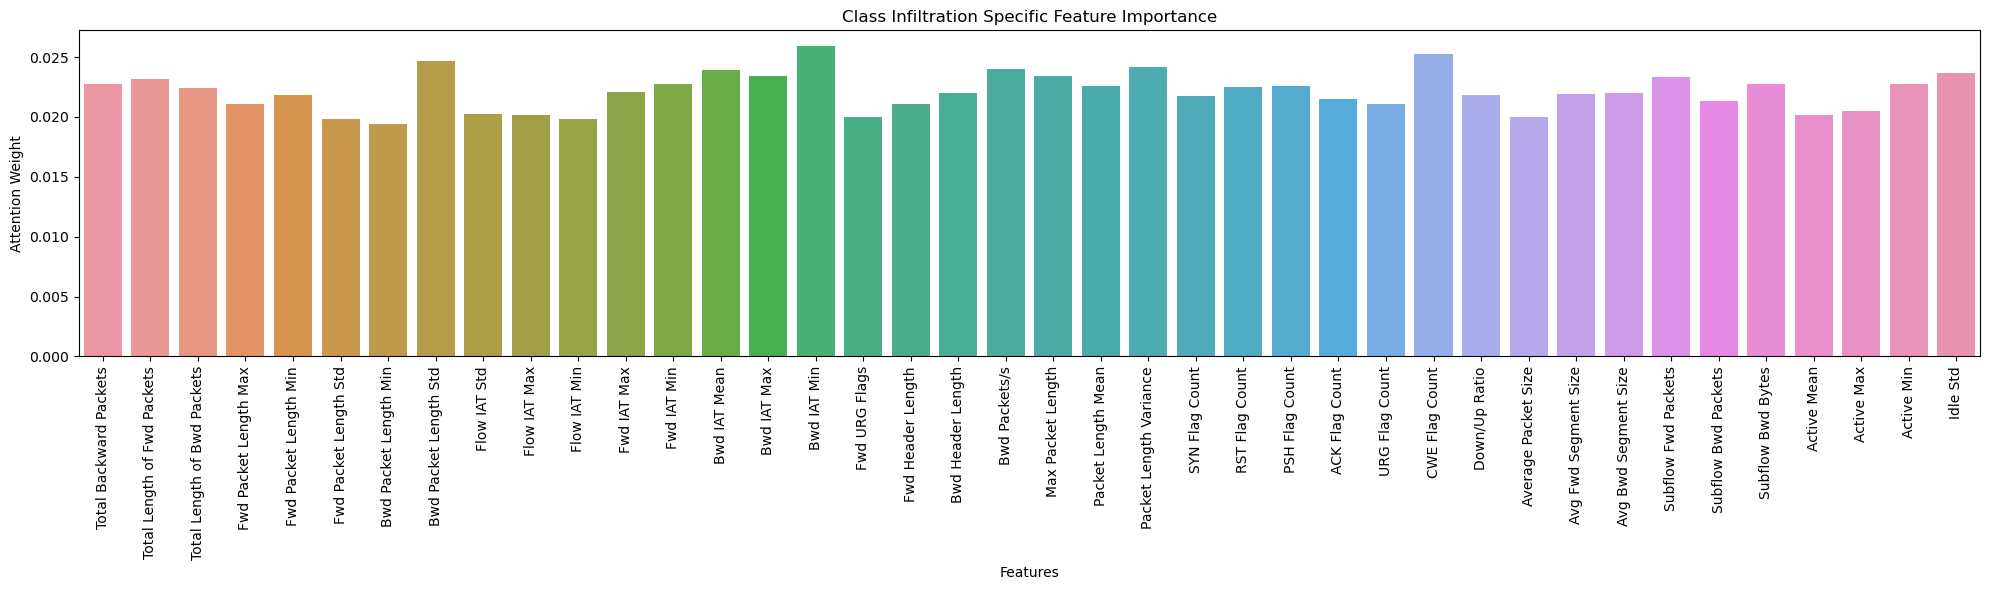

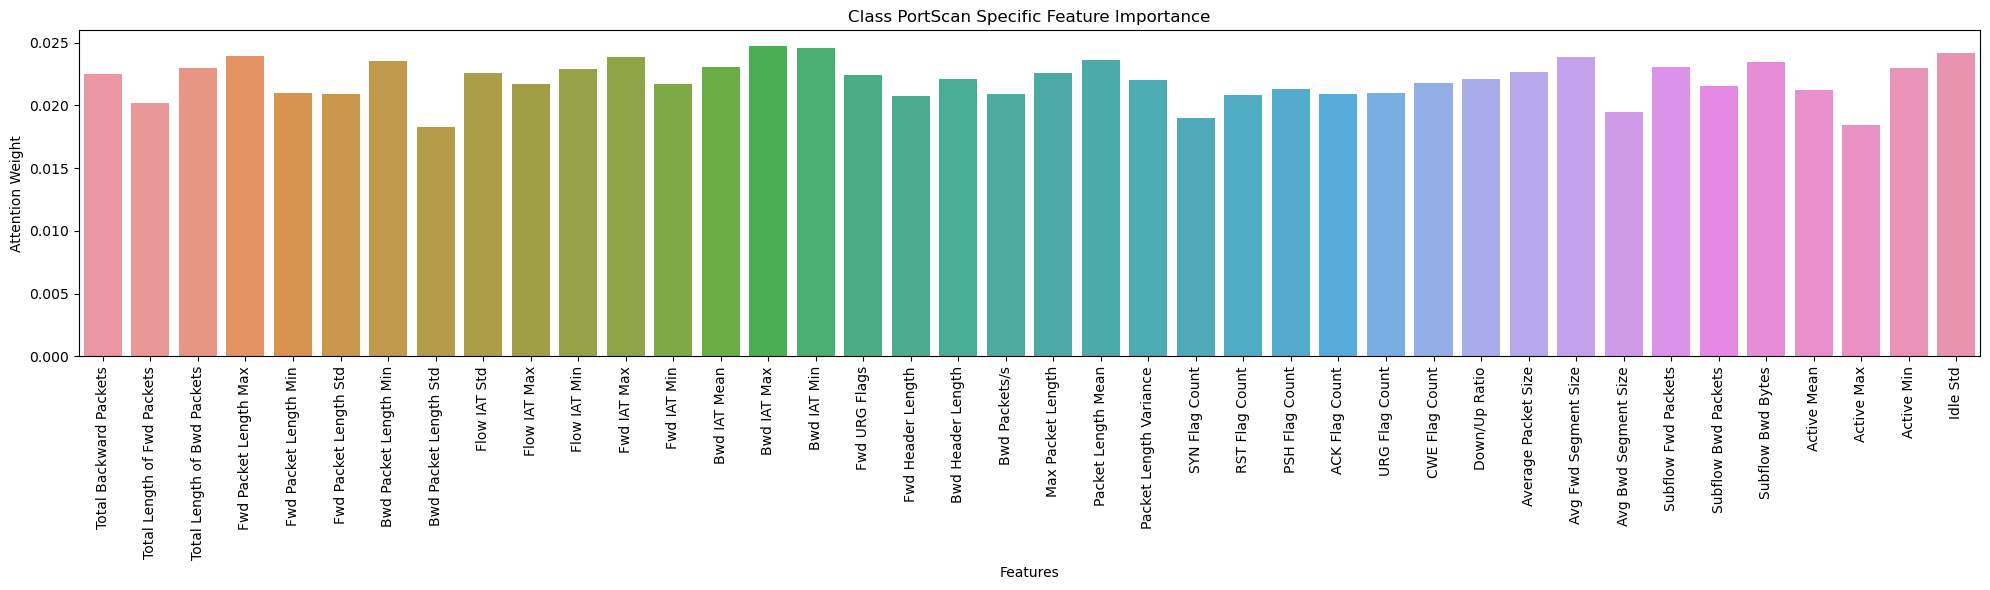

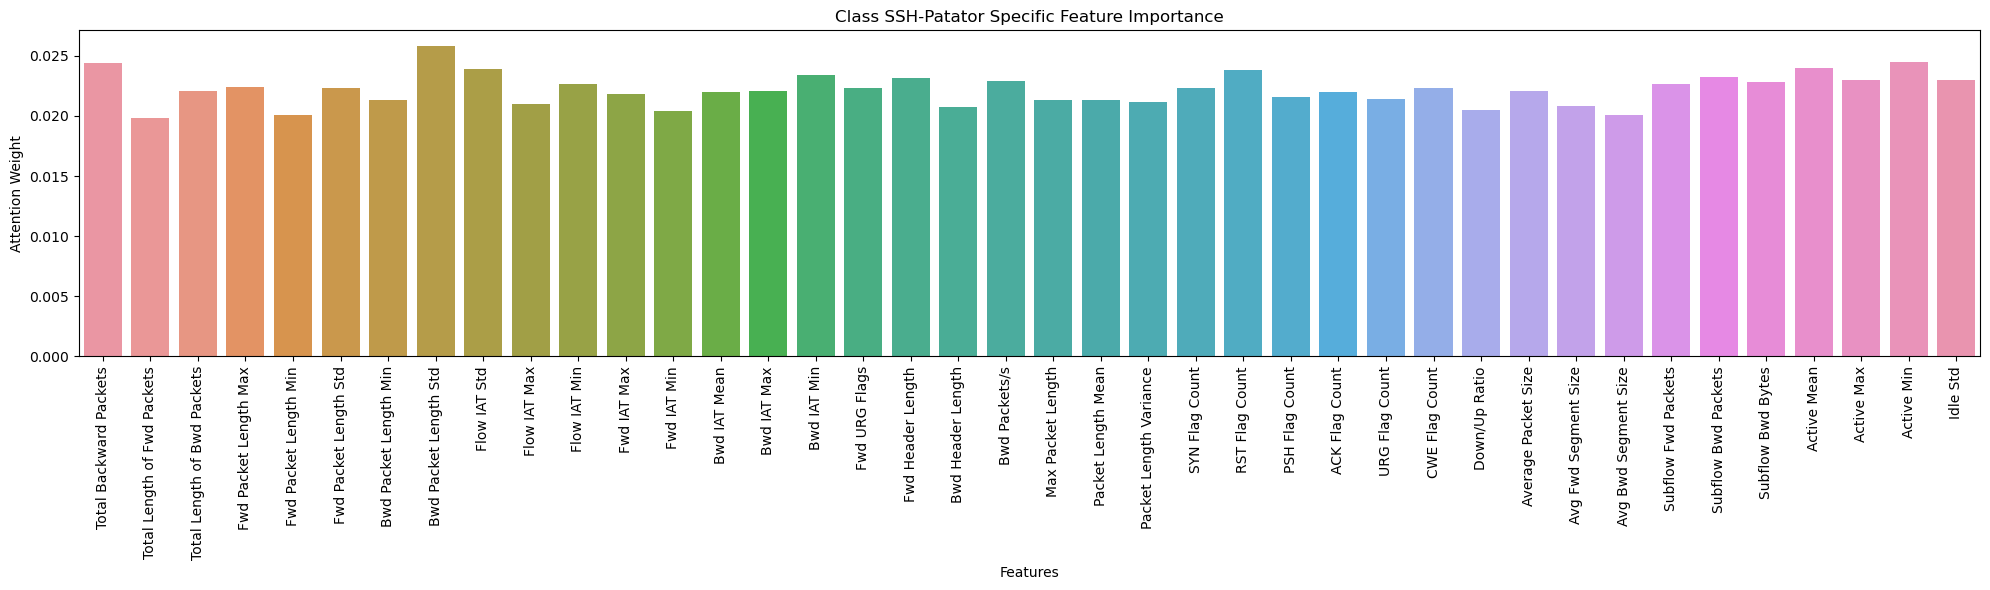

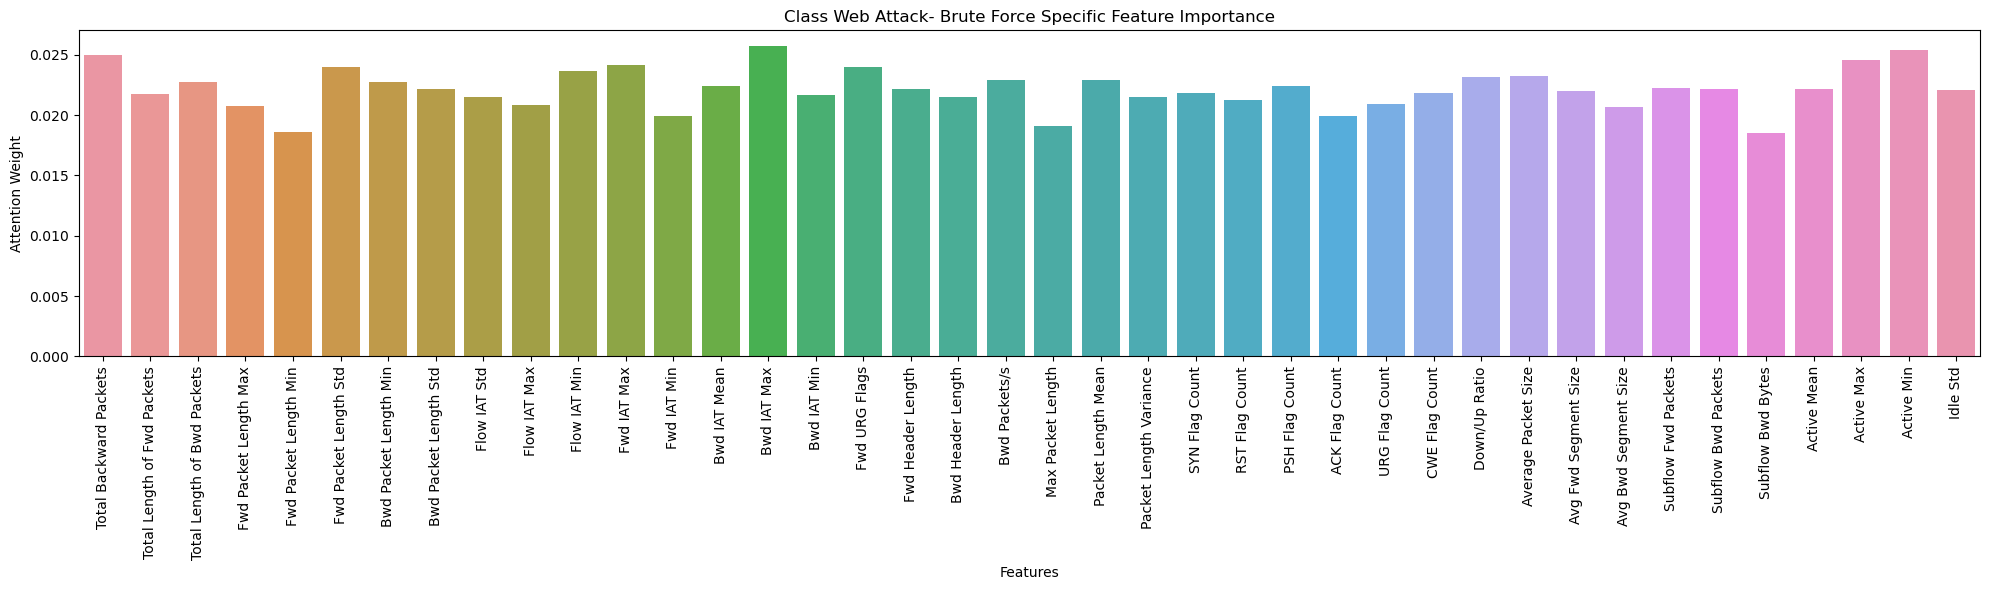

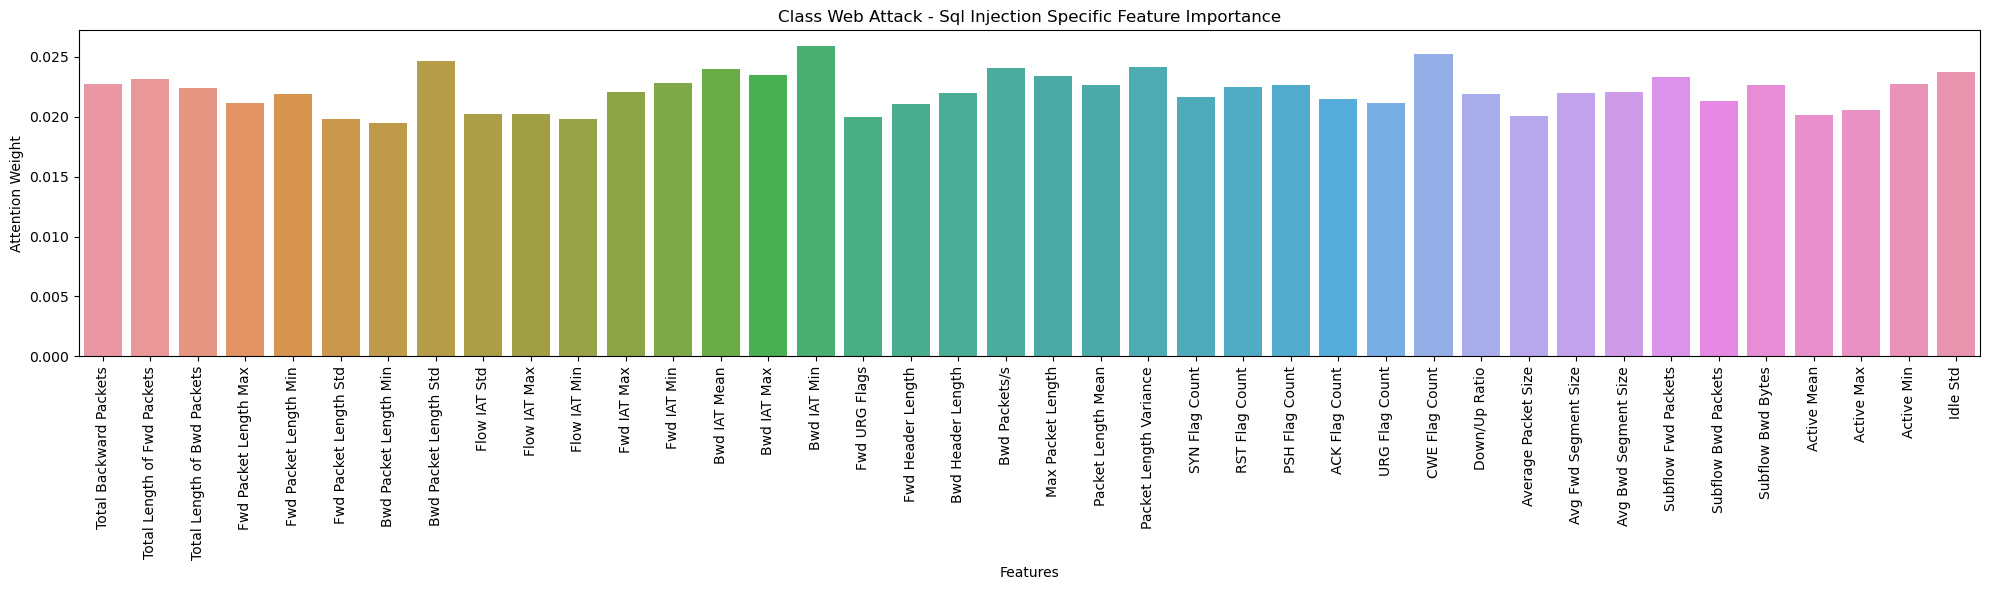

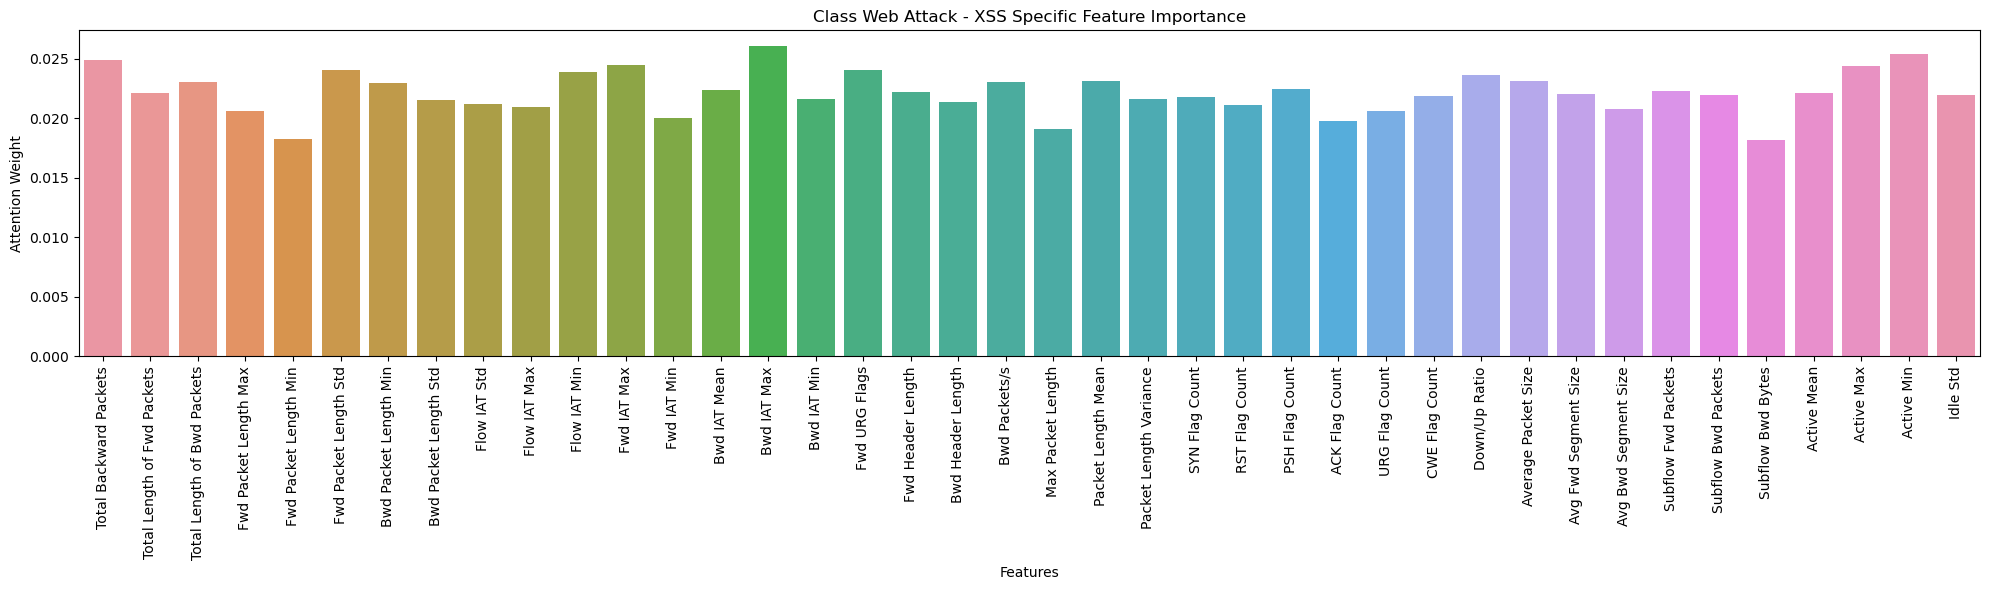

In [54]:
# Class names mapping
class_names = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 
               'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 
               'SSH-Patator', 'Web Attack- Brute Force', 'Web Attack - Sql Injection', 
               'Web Attack - XSS']
# Plot the attention weights for each class
for class_idx in range(num_classes):
    plt.figure(figsize=(20, 6))
    sns.barplot(x=selected_features, y=class_specific_weights[class_idx])
    plt.title(f'Class {class_names[class_idx]} Specific Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Attention Weight')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'class_{class_names[class_idx]}_attention_weights.png')
    plt.show()

In [95]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming `y_true_classes` and `y_pred_classes` contain the true and predicted class labels respectively
# `class_names` contains the names of each class
n_classes = len(class_names)

# Binarize the true class labels for a "one-vs-rest" approach
y_true_binarized = label_binarize(y_true_classes, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_classes, classes=range(n_classes))

In [93]:
# Class names mapping
class_names = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 
               'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 
               'SSH-Patator', 'Web Attack- Brute Force', 'Web Attack - Sql Injection', 
               'Web Attack - XSS']

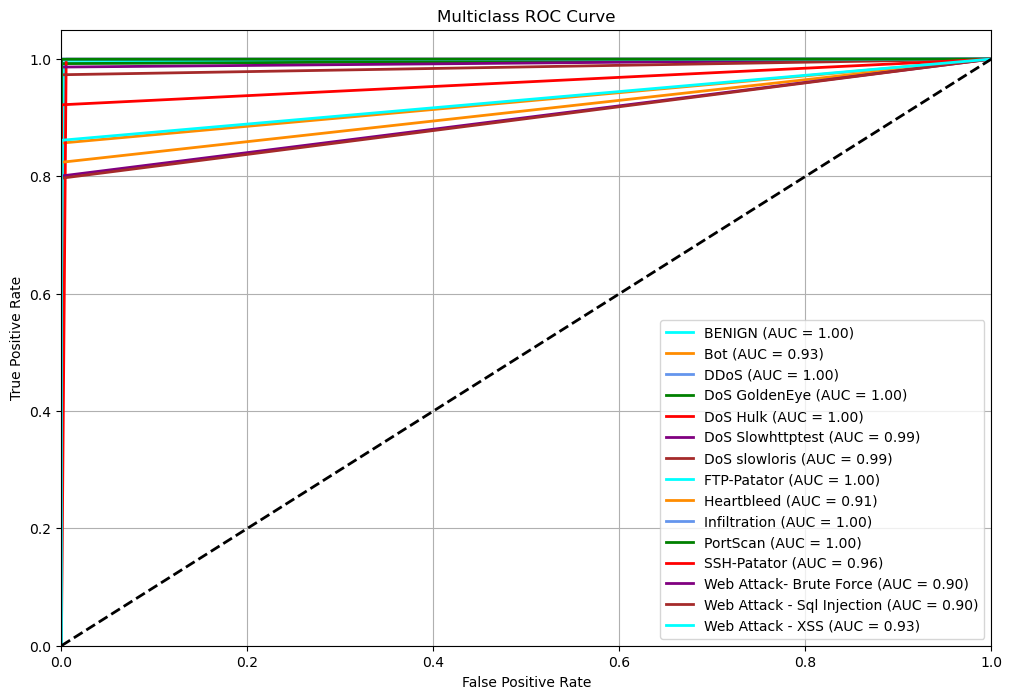

In [96]:
# ROC Curve
plt.figure(figsize=(12, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('CIC-IDS2017_multiclass_ROC.png')
plt.show()


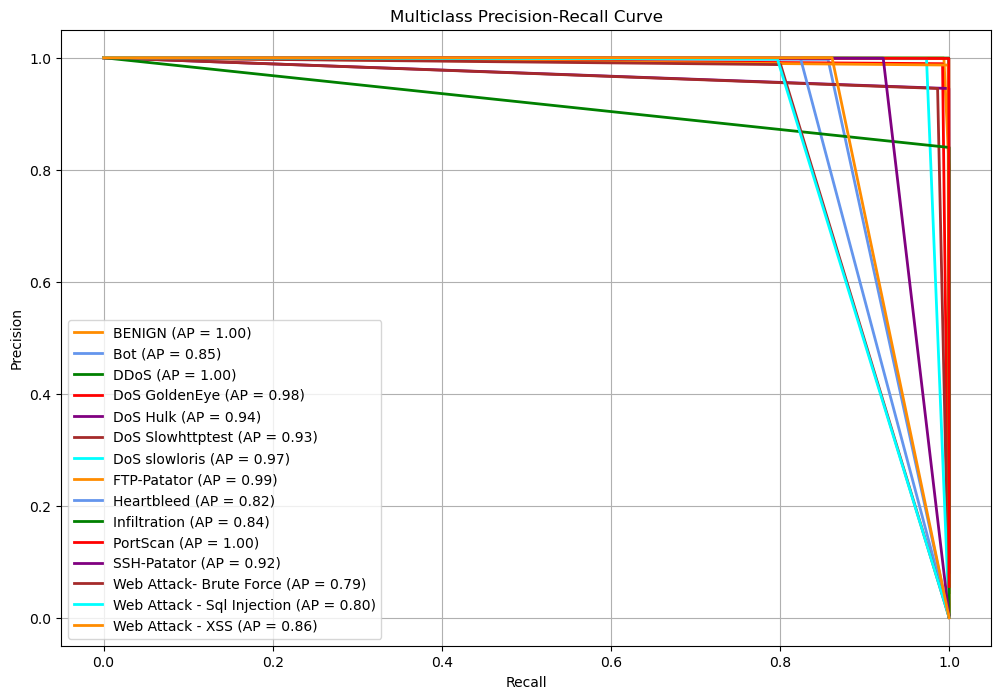

In [97]:
# Precision-Recall Curve
plt.figure(figsize=(12, 8))
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    average_precision = average_precision_score(y_true_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'{class_names[i]} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig('CIC-IDS-2017_multiclass_precision_recall.png')
plt.show()

17729/17729 ━━━━━━━━━━━━━━━━━━━━ 342s 19ms/step


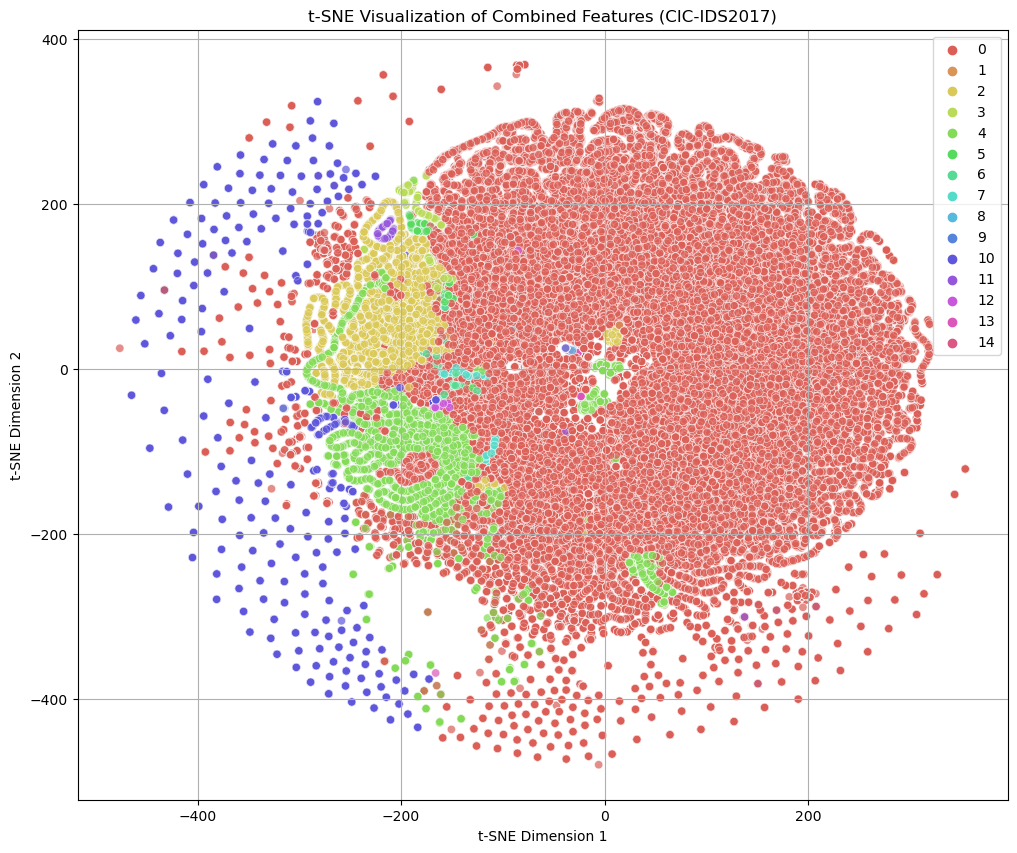

In [58]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Extract combined features from the ensemble model before the attention mechanism
# Assuming 'combined_features' is the last layer before attention in your model
feature_extractor = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('combined_features').output)
combined_features_test = feature_extractor.predict([X_test_cnn, X_test_cnn, X_test])

# Perform t-SNE to reduce the combined features to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(combined_features_test)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Label': y_true_classes  # Use the true class labels from test data
})

# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Label',  # Color by class labels
    palette=sns.color_palette('hls', len(label_encoder.classes_)),  # Use distinct colors for each class
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Combined Features (CIC-IDS2017)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('CIC_IDS2017_t-SNE_multiclass_latest.png')
plt.show()


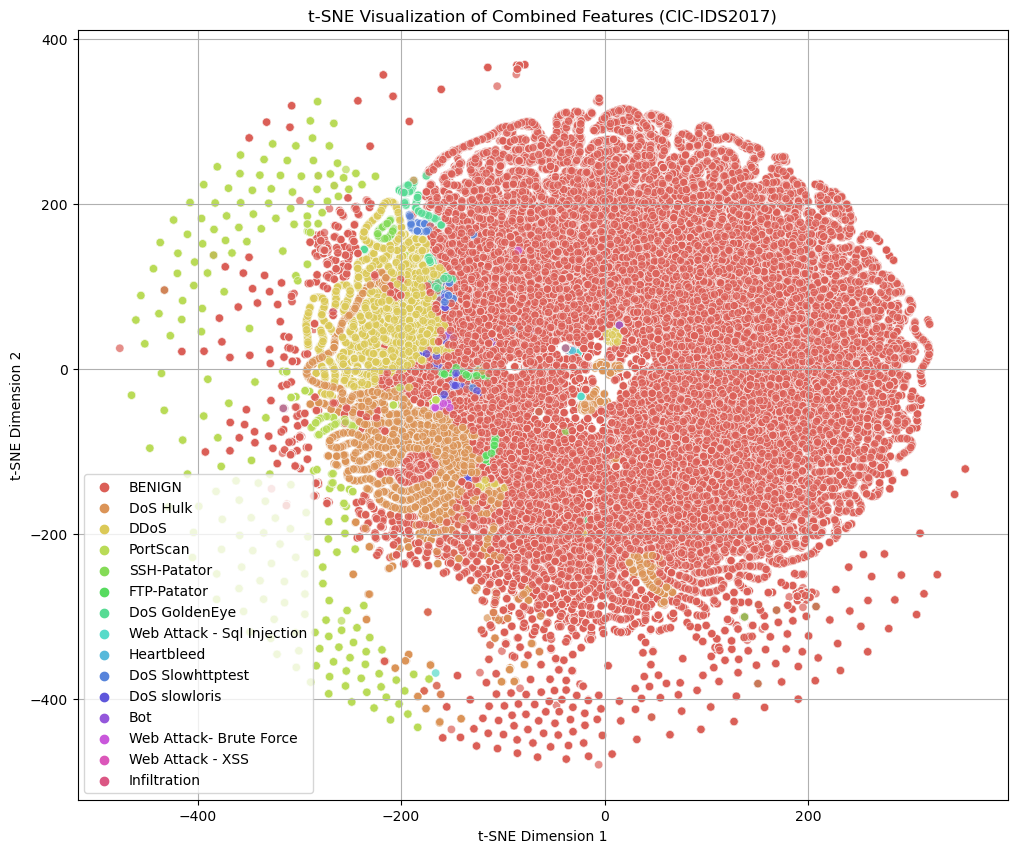

In [59]:
# Mapping the encoded labels to the actual class names
class_names = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 
               'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 
               'SSH-Patator', 'Web Attack- Brute Force', 'Web Attack - Sql Injection', 
               'Web Attack - XSS']

# Create a new column in tsne_df for the attack names
tsne_df['Attack_Name'] = tsne_df['Label'].map(lambda x: class_names[x])

# Now plot using the attack names instead of class labels
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Attack_Name',  # Color by attack names
    palette=sns.color_palette('hls', len(class_names)),  # Use distinct colors for each attack
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Combined Features (CIC-IDS2017)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('CIC_IDS2017_t-SNE_multiclass_attack_names.png')
plt.show()